# Load Modules

In [ ]:
from IPython.display import clear_output
import time
import logging
import warnings

logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
! pip3 install pyxdf
! pip3 install mne
! pip3 install neurokit2
! pip3 install Pympler
! pip3 install ydata-profiling

! mkdir preprocessed_data
! mkdir features
! mkdir plots

time.sleep(0.1)
clear_output()

print(f" ")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import yaml

import numpy as np

from tqdm import tqdm

import joblib
import importlib

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

import pandas as pd
# from ydata_profiling import ProfileReport

import sys
import gc
import tracemalloc

import math

In [ ]:
import pyxdf
import neurokit2 as nk

import functions as fnc
importlib.reload(fnc)

import sp as sp
importlib.reload(sp)

from functions import STIMULUS_FILENAME, XDF_DIR, TARGET_STREAM, STIMULUS_STREAMS, RESTING_STREAMS, MARKER_STREAMS, FRISSON_MARKER_STREAMS, TARGET_EVENTS, LABELS, DURATIONS
from functions import PREPROCESSED_DIR, FEATURES_DIR, DATASET_DIR
from functions import CHILL_EVENTS_DIR, CHILLS_DATA_DIR, NON_CHILLS_DATA_DIR, FRISSON_CHILLS_DATA_DIR
from functions import TIME_WINDOW, PLOT_TIME_WINDOW, CHILLS_REPORT_WINDOW

from scipy import signal, integrate
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
from extract import *

In [ ]:
# TIME_WINDOW = 6
# CHILLS_REPORT_WINDOW = 3
# PLOT_TIME_WINDOW = 15

phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

# Preprocessing

In [ ]:
# @title preprocessing of data

subjects_info = fnc.subjects_info(STIMULUS_FILENAME)

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

# subjects = ["5082"]

subjects_preprocessed_data = dict()

for s, subject in enumerate(subjects):

  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")

  if os.path.exists(os.path.join(subject_path))!=True:

    print(f"{s+1}/{len(subjects)}: {subject}")
    print(f"-------------------------------------------------------------------")

    # GET ORDER of STIMULUS PRESENTATION
    stimulus_order = fnc.get_stimulus_order(subject, subjects_info)
    if not stimulus_order:
        continue
    print(f"Stimulus Order for subject {subject}: {stimulus_order}")

    # LOAD XDF FILE
    xdf_file_path = os.path.join(XDF_DIR, f"{subject}.xdf")
    try:
        streams, _ = pyxdf.load_xdf(xdf_file_path)
        chills_timestamps = fnc.process_markers(streams, MARKER_STREAMS, TARGET_EVENTS)
        frisson_timestamps = fnc.process_markers(streams, FRISSON_MARKER_STREAMS, TARGET_EVENTS)
    except FileNotFoundError:
        print(f"Error: The file {xdf_file_path} was not found.")
        continue
    except Exception as e:
        print(f"An error occurred while loading {xdf_file_path}: {e}")
        continue

    # GET STIMULUS/RESTING STATE ONSET
    stimulus_latencies = fnc.process_markers(streams, STIMULUS_STREAMS, TARGET_EVENTS)
    resting_latencies = fnc.process_markers(streams, RESTING_STREAMS, TARGET_EVENTS)
    print(f"Stimulus latencies: {stimulus_latencies}")
    print(f"Resting latencies: {resting_latencies}")
    for stream in STIMULUS_STREAMS:
        stimulus_latencies_ordered = {i: stimulus_latencies[stream][stimulus_order.index(i)] for i in
                                        stimulus_order}
    print(f"Stimulus Latencies: {stimulus_latencies_ordered}")

    # EXTRACT DATA
    data, stream = fnc.extract_raw_data(streams, TARGET_STREAM, LABELS)
    if data is None:
        continue

    # GET SAMPLING RATE
    timestamps = data["Timestamps"]
    effective_fs = sp.estimate_sampling_rate(timestamps)
    sampling_rate = int(np.round(effective_fs))
    print(f"Sampling Rate: {sampling_rate}")

    if 'desc' in stream['info'] and 'channels' in stream['info']['desc'][0]:
        channel_labels = stream['info']['desc'][0]['channels'][0]['channel']
        channel_names = [ch['label'][0] for ch in channel_labels]
        print("Channel names:", channel_names)

        concatenated_data = fnc.extract_and_concatenate_data(
            data, timestamps, sampling_rate, stimulus_latencies_ordered, resting_latencies, stimulus_order
        )

        preprocessed_data = dict()
        for epoch in concatenated_data["epochs"]:
          data = concatenated_data["epochs"][epoch]
          data["Timestamps"] = concatenated_data["timestamps"][epoch]
          output = sp.preprocess_data(data)
          preprocessed_data[epoch] = output
        preprocessed_data["chills"] = chills_timestamps
        preprocessed_data["frisson_chills"] = frisson_timestamps

        if os.path.exists(subject_path) is not True:
          joblib.dump(preprocessed_data, subject_path)
          # subjects_preprocessed_data[subject] = preprocessed_data

    time.sleep(0.01)
    clear_output()

time.sleep(0.01)
clear_output()
print(f"")

In [ ]:
# @title Check Subjects Not Processed

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

for subject in subjects:
  if os.path.exists(os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")) is False:
    print(subject)

5008


# Subject Data Validity

In [ ]:


# @title Get Subject_Epochs_Validity Dataframe




subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

preprocessed_data = os.listdir(PREPROCESSED_DIR)
# subject = 5075

columns_ = [[(phase, "Same_Signal_Length"), (phase, "ECG_Fit"), (phase, "EDA_Fit")] for phase in phases]
columns_ = list(chain(*columns_))
columns_.append(("Chill_Events_Present", " "))
midx = pd.MultiIndex.from_tuples(columns_)
signal_exclusion_df = pd.DataFrame(columns=midx, index=subjects)

for s, subject in enumerate(subjects):
  processed_file = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(processed_file) is False:
    continue
  data = joblib.load(os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav"))
  for phase in phases:
    if phase in data:
      signal_exclusion_df.loc[subject, (phase, "Same_Signal_Length")] = ((len(data[phase]["ecg_cleaned"]) == len(data[phase]["resp_cleaned"]) == len(data[phase]["df"])))
      signal_exclusion_df.loc[subject, (phase, "ECG_Fit")] = True if data[phase]["Exclusion_Status_ECG"]=="Acceptable" else False
      signal_exclusion_df.loc[subject, (phase, "EDA_Fit")] = True if data[phase]["Exclusion_Status_EDA"]=="Acceptable" else False
    else:
      signal_exclusion_df.loc[subject, (phase, "Same_Signal_Length")] = False
      signal_exclusion_df.loc[subject, (phase, "ECG_Fit")] = False
      signal_exclusion_df.loc[subject, (phase, "EDA_Fit")] = False
  signal_exclusion_df.loc[subject, ("Chill_Events_Present", " ")] = True if len(data["chills"]["ChillsReport"])>0 else False
  print(f"Extracting Data Validity for subject: {subject}, {s+1}/{len(subjects)}")
clear_output(wait=True)
time.sleep(0.25)

signal_exclusion_df.to_pickle("drive/MyDrive/chills_dataset/Subject_Epochs_Validity.pkl")

clear_output(wait=True)
time.sleep(0.25)

signal_exclusion_df.head(5)

pre_rest                          stimulus1                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004              False   False   False               True    True    True   

              stimulus2                          stimulus3                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004               True    True    True               True    True    True   

              post_rest                 Chill_Events_Present  
     Same_Signal_Length ECG_Fit EDA_Fit                       
5002               True    True    True                False  
5006               True    True    True                False  
5001               True    True    True                False  
5007               True    True    True                False  
5004              False   False   False                False

In [ ]:
subjects_epochs_validity = pd.read_pickle(os.path.join(DATASET_DIR, "Subject_Epochs_Validity.pkl"))
subjects_epochs_validity.head(5)

pre_rest                          stimulus1                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004              False   False   False               True    True    True   

              stimulus2                          stimulus3                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004               True    True    True               True    True    True   

              post_rest                 Chill_Events_Present  
     Same_Signal_Length ECG_Fit EDA_Fit                       
5002               True    True    True                False  
5006               True    True    True                False  
5001               True    True    True                False  
5007               True    True    True                False  
5004              False   False   False                False

# View Events $ Event Statistics

In [ ]:
subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]
no_subjects = len(subjects_epochs_validity)
no_epochs = len(stimuli_phases)
no_subjects, no_epochs

(115, 3)

In [ ]:
# @title Identify Chill Events

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

subjects_with_chills = list()  # --> All subjects with chills reports in stimuli phases
chills_events = dict()
# chills_events

# --> FIND ALL SUBJECTS WITH CHILL REPORTS
for s, subject in enumerate(subjects):
  file_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(file_path) is False:
    continue
  subject_data = joblib.load(file_path)

  chills_ts = np.array(subject_data["chills"]["ChillsReport"])
  if len(chills_ts)>0:
    for phase in stimuli_phases:
      phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
      _ts = (chills_ts >= phase_ts[0]) & (chills_ts <= phase_ts[-1])
      _ts = _ts.sum()
      if _ts>0:
        subjects_with_chills.append(subject)
        break

  # --> IDENTIFY & SAVE TIMESTAMP OF CHILL REPORTS FOR ALL SUBJECTS IN STIMULI PHASES: [stimulus1, stimulus2, stimulus3]

  if subject in subjects_with_chills:
    chills_events[subject] = dict()
    chills_ts = np.array(subject_data["chills"]["ChillsReport"])

    fs = 0
    for phase in stimuli_phases:
      phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
      fs += subject_data[phase]["effective_sampling_rate"]
      idx = (chills_ts >= phase_ts[0]) & (chills_ts <= phase_ts[-1])
      chills_events[subject][phase] = chills_ts[idx]
    chills_events[subject]["fs"] = fs/3
    print(f"{s}/{len(subjects)}: {subject} Chill Events Saved")

clear_output(wait=True)
time.sleep(0.25)
print("")
del subject_data, fs, idx, _ts, phase_ts

joblib.dump({
    "subjects": subjects_with_chills,
    "events": chills_events
}, CHILL_EVENTS_DIR)

['drive/MyDrive/chills_dataset/processed/chill_events.sav']

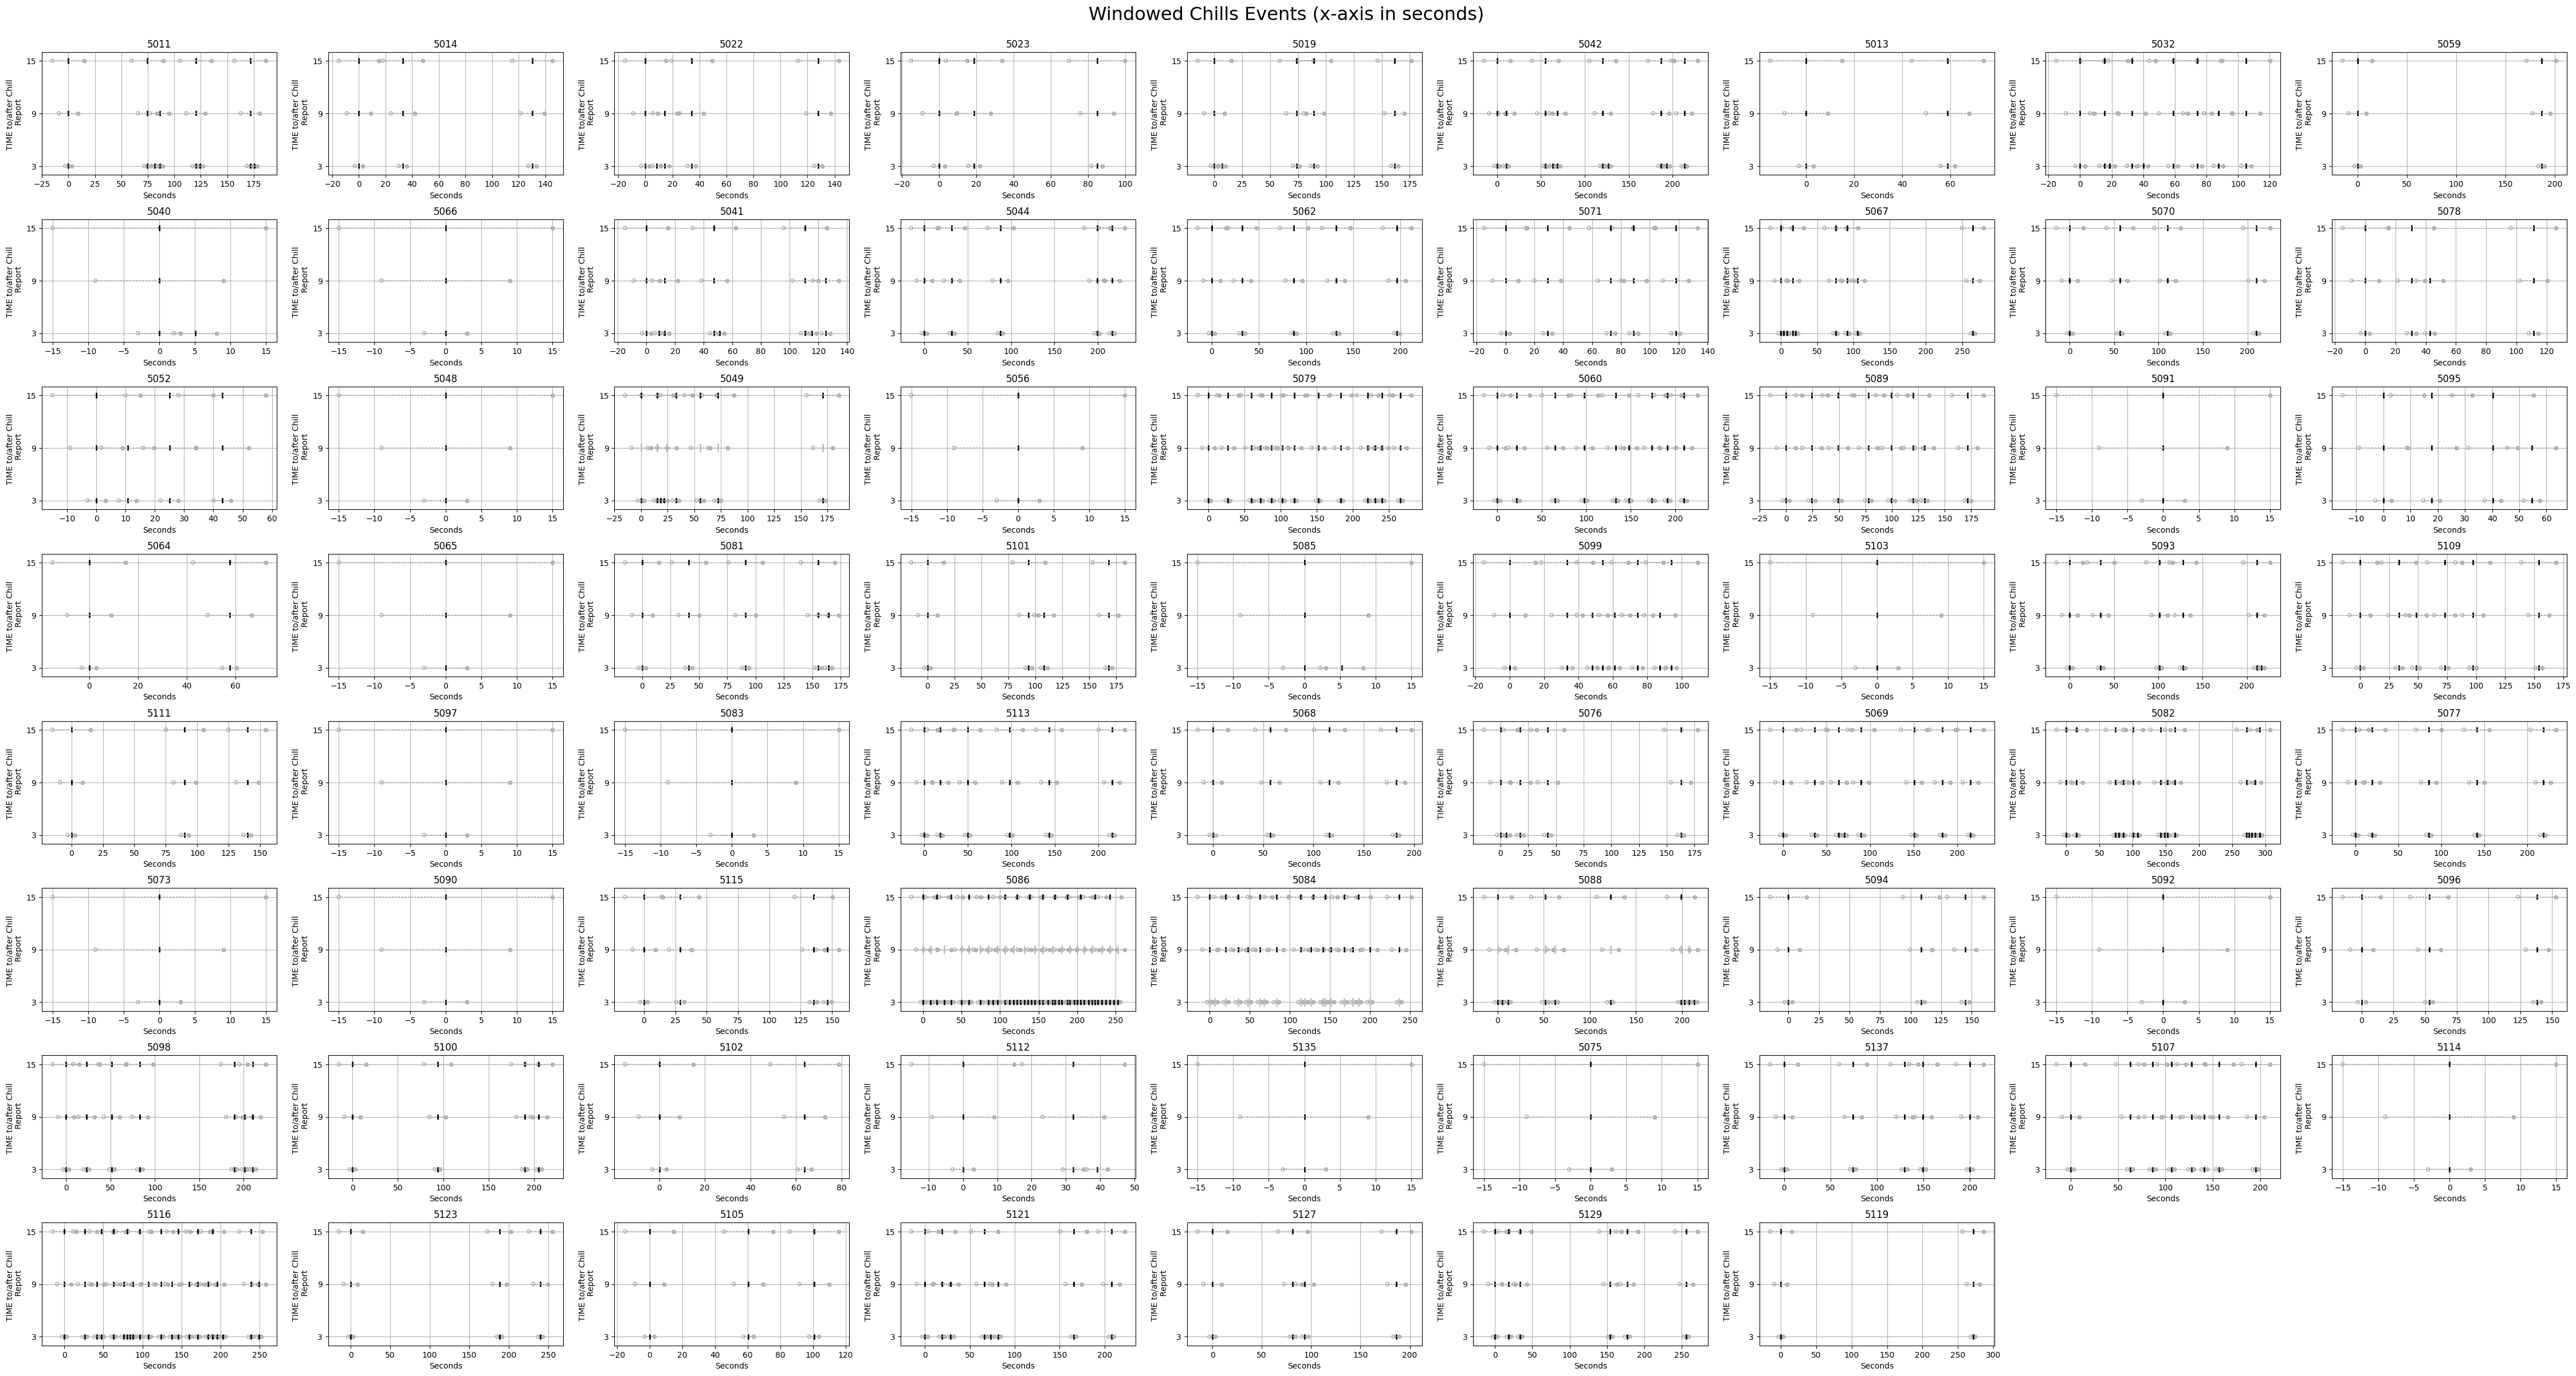

In [ ]:
# @title Plot Chill Events

chill_events = joblib.load(CHILL_EVENTS_DIR)
subjects_with_chills = chill_events["subjects"]
chills_events = chill_events["events"]

nrows = ncols = math.ceil(math.sqrt(len(subjects_with_chills)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3))

times_ = [3, 9, 15]
start, end, steps = times_[0], times_[-1], times_[1]-times_[0]
for time_window in times_:

  for s, subject in enumerate(subjects_with_chills):

    ts = None
    for phase in stimuli_phases:
      if ts is None and len(chills_events[subject][phase])>0:
        ts = chills_events[subject][phase]
      elif len(chills_events[subject][phase])>0:
        np.hstack((ts, chills_events[subject][phase]))
    fs = chills_events[subject]["fs"]

    consolidated_chills = [ts[0]]
    for t in ts[1:]:
      if t - consolidated_chills[-1] > time_window:
        consolidated_chills.append(t)
    ts = np.array(consolidated_chills)

    # print(f"{subject}: {ts}")
    # ax.flatten()[s].stem(ts-ts.min(), np.ones(len(ts)), basefmt=" ", markerfmt="yo", linefmt="y-")
    ts_diff = np.diff(ts-ts.min())
    color_1 = "silver"
    color_ = "darkgray"
    color_2 = "black"
    if (ts_diff < (time_window + 0.1)).sum() > 0:
      ax.flatten()[s].vlines(x=ts-ts.min(), ymin=time_window-0.5, ymax=time_window+0.5, colors=color_1, linewidth=2.0)
    else:
      ax.flatten()[s].vlines(x=ts-ts.min(), ymin=time_window-0.3, ymax=time_window+0.3, colors=color_2, linewidth=2.0)
    for x in ts - ts.min():
        ax.flatten()[s].hlines(y=time_window, xmin=x-time_window, xmax=x+time_window, colors=color_, linewidth=1.5, linestyle="dotted")
    ax.flatten()[s].scatter(ts-ts.min()-time_window, np.zeros(len(ts))+time_window, edgecolors=color_, facecolors="none", s=20)
    ax.flatten()[s].scatter(ts-ts.min()+time_window, np.zeros(len(ts))+time_window, edgecolors=color_, facecolors=color_1, s=20)

    ax.flatten()[s].set_ylim(start-1, end+1)
    ax.flatten()[s].set_ylabel("TIME to/after Chill \n Report")
    ax.flatten()[s].set_xlabel("Seconds")
    ax.flatten()[s].set_title(subject)
    ax.flatten()[s].grid(True)
    ax.flatten()[s].set_yticks(times_)

  for s_ in range(s+1,len(ax.flatten())):
    ax.flatten()[s_].set_visible(False)

# for s_ in range(s+1,len(ax.flatten())):
#   ax.flatten()[s_].set_yticks(list(range(start, end, steps)))

fig.tight_layout()
fig.suptitle(f"Windowed Chills Events (x-axis in seconds)", fontsize=23)
fig.subplots_adjust(top=0.95)
fig.savefig(f"plots/windowed_chill_events.png")
# plt.close(fig)

# Plot Chills & Rest Signals

In [ ]:
chills_data = joblib.load(CHILLS_DATA_DIR)
non_chills_data = joblib.load(NON_CHILLS_DATA_DIR)

In [ ]:
# @title Plot Chill Onset & Offset Signals

from scipy.signal import decimate

# --> GET TOTAL NUMBER OF CHILL EVENTS
chills_count = dict()
for p, phase in enumerate(stimuli_phases):
  chills_count[phase] = 0
  for s, subject in enumerate(chills_data.keys()):
    chills_count[phase] += len(chills_data[subject][phase])
print(f"NO OF CHILLS EVENTS: {chills_count}")

# --> PLOT CHILLS EVENTS DATA FOR EACH STIMULI PHASE
# tracemalloc.start()
for p, phase in enumerate(stimuli_phases):
  idx = 0
  nrows = math.ceil(math.sqrt(chills_count[phase]))
  ncols = nrows

  plt.ioff()
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), dpi=100)
  for s, subject in enumerate(chills_data.keys()):
    for event in chills_data[subject][phase]:
      signal_ = None
      ts = None
      if (event["pre"] is not None) and (signal_ is None):
        signal_ = event["pre"]
        ts = np.linspace(-1 * PLOT_TIME_WINDOW, 0, signal_.shape[0])
      if (event["post"] is not None) and (signal_ is not None):
        signal_ = np.concatenate([signal_, event["post"]])
        ts = np.linspace(-1 * PLOT_TIME_WINDOW, PLOT_TIME_WINDOW, signal_.shape[0])
      elif (event["post"] is not None) and (signal_ is None):
        signal_ = event["post"]
        ts = np.linspace(0, PLOT_TIME_WINDOW, signal_.shape[0])
      if signal_ is not None:
        # print(signal_.shape)
        decimation_factor = int(0.005*signal_.shape[0])
        signal = signal_[::decimation_factor]
        ts = ts[::decimation_factor]
        for c in range(4):
          if c==0 or c==3:
            color_ = "grey" if subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")]==True else "mistyrose"
          else:
            color_ = "grey"
          ax.flatten()[idx].plot(ts, signal[:,c] + (3-c), color=color_)
        ax.flatten()[idx].set_title(f"{subject}-{phase}")
        ax.flatten()[idx].set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.flatten()[idx].set_yticklabels(["ECG", "RESP", "EMG", "GSR"])
        if ((ts.any() > 0) & ~(ts.any() < 0)) or (~(ts.any() > 0) & (ts.any() < 0)):
          ax.flatten()[idx].vlines(x=0, ymin=0, ymax=4.1, colors="black", linewidth=1.5, linestyle="dashed")
        idx += 1
      else:
        pass

  for s_ in range(chills_count[phase], nrows*ncols):
    ax.flatten()[s_].set_visible(False)

  if not os.path.exists("plots"):
    os.mkdir("plots")
  fig.suptitle(f"{TIME_WINDOW} {phase} chill signals", fontsize=24, y=1.02)
  fig.tight_layout()
  fig.savefig(f"plots/{phase}_chills.png", dpi=100)
  plt.close(fig)
  del fig, ax, idx, nrows, ncols, signal, signal_, ts
  print(f"{phase} signals plotted")

# mm_usage = tracemalloc.get_traced_memory()
# print(f"{np.array(mm_usage)/(1024*1024)} MB | {(mm_usage[1]-mm_usage[0])/(1024*1024)}MB")
# tracemalloc.stop()
gc.collect()

NO OF CHILLS EVENTS: {'stimulus1': 830, 'stimulus2': 895, 'stimulus3': 910}
stimulus1 signals plotted
stimulus2 signals plotted
stimulus3 signals plotted


192

In [ ]:
rest_phases

['pre_rest', 'post_rest']

In [ ]:
# @title Plot Non-Chills Signals

# --> GET TOTAL NUMBER OF REST
rest_count = dict()
for p, phase in enumerate(rest_phases):
  rest_count[phase] = 0
  for s, subject in enumerate(non_chills_data):
    rest_count[phase] += len(non_chills_data[subject][phase])
print(f"NO OF REST: {rest_count}")

# --> PLOT CHILLS EVENTS DATA FOR EACH STIMULI PHASE
tracemalloc.start()
for p, phase in enumerate(rest_phases):
  idx = 0
  nrows = math.ceil(math.sqrt(rest_count[phase]))
  ncols = nrows
  plt.ioff()
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), dpi=100)

  for s, subject in enumerate(non_chills_data):
    for signal_ in non_chills_data[subject][phase]:
      decimation_factor = int(0.005*signal_.shape[0])
      signal = signal_[::decimation_factor]
      ts = np.linspace(0, signal_.shape[0]/500, signal.shape[0])
      for c in range(4):
        if c==0 or c==3:
          color_ = "grey" if subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")]==True else "mistyrose"
        else:
          color_ = "grey"
        ax.flatten()[idx].plot(ts, signal[:,c] + (3-c), color=color_)
      ax.flatten()[idx].set_title(f"{subject}-{phase}")
      ax.flatten()[idx].set_yticks([0.5, 1.5, 2.5, 3.5])
      ax.flatten()[idx].set_yticklabels(["ECG", "RESP", "EMG", "GSR"])
      idx += 1

  for s_ in range(rest_count[phase], nrows*ncols):
    ax.flatten()[s_].set_visible(False)

  if not os.path.exists("plots"):
    os.mkdir("plots")
  fig.suptitle(f"{phase} non-chill signals", fontsize=18)
  fig.tight_layout()
  fig.savefig(f"plots/{phase}_non_chill_signals.png", dpi=100)
  plt.close(fig)

mm_usage = tracemalloc.get_traced_memory()
print(f"{np.array(mm_usage)/(1024*1024)} MB | {(mm_usage[1]-mm_usage[0])/(1024*1024)}MB")
tracemalloc.stop()
gc.collect()

del fig, ax, idx, nrows, ncols

NO OF REST: {'pre_rest': 78, 'post_rest': 96}
[79.64348412 79.7925415 ] MB | 0.14905738830566406MB


# Epoching & Feature Extraction

## Epochs Extraction

In [ ]:
# --> Get Name of All subject xdf files
# subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(PREPROCESSED_DIR)
# Athentic Chills Epochs extracted in chunks
  # Chunk1 --> 0:50
  # Chunk2 --> 50:100
  # Chunk3 --> 100:
subjects = [subject[:4] for subject in subjects]

'''PREDEFS for EXTRACTING EVENTS DATA EPOCSH'''
subjects_epochs_validity = pd.read_pickle(os.path.join(DATASET_DIR, "Subject_Epochs_Validity.pkl")) # --> Load Subjects Epochs Validity DataFrame
# --> Define Phases
phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

# # Fetch Chill Events
# chill_events = joblib.load(CHILL_EVENTS_DIR)
# subjects_with_chills = chill_events["subjects"]
# chill_events = chill_events["events"]

In [ ]:
# @title Chills

extracted_data = {}

for s, subject in tqdm(enumerate(subjects), desc="Generating Structured Organic Chill Signals", total=len(subjects)):

  '''LOAD PREPROCESSED DATA'''
  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(subject_path) is False:
      continue
  preprocessed_data = joblib.load(subject_path)

  '''GET EPOCHS of PRE- & POST-CHILL, NON-CHILL DATA'''
  # --> PREDEFS
  subject_data = preprocessed_data
  chills_data = {phase: [] for phase in stimuli_phases}
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)

  # --> APPLY WINDOW TO CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  ts = subject_data["chills"]["ChillsReport"] #--> timestamps of all subject chill event reports
  if len(ts)==0:
    chills_ts = []
  else:
    consolidated_chills = [ts[0]]
    for t in ts[1:]:
        if t - consolidated_chills[-1] > CHILLS_REPORT_WINDOW:
            consolidated_chills.append(t)
    chills_ts = np.array(consolidated_chills)
    del consolidated_chills, ts
    gc.collect()

  # --> APPLY WINDOW TO FRISSON CHILL EVENTS TO GET NON-OVERLAPPING AUGMENTTED CHILLS STIMULATION
  fts = subject_data["frisson_chills"]["FrissonStart"]
  if len(fts)==0:
    frisson_ts = []
  else:
    frisson_consolidated = [fts[0]]
    for t in fts[1:]:
      if t - frisson_consolidated[-1] > CHILLS_REPORT_WINDOW:
        frisson_consolidated.append(t)
    frisson_ts = np.array(frisson_consolidated)
    del frisson_consolidated, fts

  # --> EXTRACT STIMULI PHASE EVENTS DATA
  for p, phase in enumerate(stimuli_phases):
    if phase in subject_data:

      if (subjects_epochs_validity.loc[subject, (phase, "Same_Signal_Length")] is True) and \
       (subjects_epochs_validity.loc[subject, (phase, "ECG_Fit")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")] is True): # --> All signal quality checks must be met

          # --> FORM MULTIVARIATE SIGNAL OF [GSR/EDA, EMG, RESP, ECG] FOR SUBJECT-PHASE
          ecg = sp.normalize_signal(np.array(subject_data[phase]["ecg_cleaned"]))
          resp = sp.normalize_signal(np.array(subject_data[phase]["resp_cleaned"]))
          emg = sp.normalize_signal(np.array(subject_data[phase]["df"]["EMG"]))
          gsr = sp.normalize_signal(np.array(subject_data[phase]["df"]["GSR_Interpolated"]))
          phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
          fs = subject_data[phase]["effective_sampling_rate"]
          signal = np.stack([gsr, emg, resp, ecg], axis=1)

          # --> EXTRACT SIGNAL OF DURATION TIME_WINDOW PRIOR TO AND AFTER CHILL EVENT FOR SUBJECT-PHASE, TO BE RECOMBINED INTO CONTINUOUS SIGNAL LATER
          sig = None
          for ts in chills_ts:

            if ts < phase_ts[0] or ts > phase_ts[-1]:
              continue
            if len(frisson_ts)!=0  and np.any(np.abs(frisson_ts - ts)<=3):
              # Skip any organic chills report that falls within 3 seconds of frisson induced chills
              continue

            midx = marker_idx = np.searchsorted(phase_ts, ts)
            n_samples = int(fs*time_window)

            pre_chill, post_chill = None, None
            aug_sig = None
            if midx >= n_samples//2:
              pre_chill = signal[:midx, :]
              if pre_chill.shape[0] < n_samples:
                aug_sig = np.mean(pre_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-pre_chill.shape[0], 1))
                pre_chill = np.vstack((aug_sig, pre_chill))
              elif pre_chill.shape[0] >= n_samples:
                pre_chill = pre_chill[-n_samples:, :]
            if midx <= signal.shape[0] - n_samples//2:
              if signal.shape[0]-midx >=n_samples:
                post_chill = signal[midx:midx+n_samples]
              else:
                post_chill = signal[midx:, :]
                aug_sig = np.mean(post_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-post_chill.shape[0], 1))
                post_chill = np.vstack((post_chill, aug_sig))

            new_sample = {}
            if (pre_chill is not None) and (pre_chill.shape[0] > 0):
              new_sample["pre"] = pre_chill
            if (post_chill is not None) and (post_chill.shape[0] > 0):
              new_sample["post"] = post_chill

            if len(new_sample) > 0:
              chills_data[phase].append(new_sample)

            del pre_chill, post_chill, aug_sig, n_samples, new_sample
          del ecg, resp, emg, gsr, phase_ts, fs, signal

  extracted_data[subject] = chills_data

# joblib.dump(extracted_data, CHILLS_DATA_DIR)
joblib.dump(extracted_data, "drive/MyDrive/chills_dataset/processed/organic_chills_signal_chunk_1.sav")
del extracted_data
gc.collect()

Generating Structured Organic Chill Signals: 100%|██████████| 114/114 [09:08<00:00,  4.81s/it]


0

In [ ]:
# @title Frisson + Chills => Augmented Chills

extracted_data = {}
subject_frisson_counts = {}

for s, subject in tqdm(enumerate(subjects), desc="Extracting Features", total=len(subjects)):

  '''LOAD PREPROCESSED DATA'''
  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(subject_path) is False:
      continue
  preprocessed_data = joblib.load(subject_path)

  '''GET EPOCHS of PRE- & POST-CHILL, NON-CHILL DATA'''
  # --> PREDEFS
  subject_data = preprocessed_data
  chills_data = {phase: [] for phase in stimuli_phases}
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)

  # --> APPLY WINDOW TO CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  ts = subject_data["chills"]["ChillsReport"] #--> timestamps of all subject chill event reports
  if len(ts)==0:
    chills_ts = []
  else:
    consolidated_chills = [ts[0]]
    for t in ts[1:]:
        if t - consolidated_chills[-1] > CHILLS_REPORT_WINDOW:
            consolidated_chills.append(t)
    chills_ts = np.array(consolidated_chills)
    del consolidated_chills, ts
    gc.collect()

  # --> APPLY WINDOW TO FRISSON CHILL EVENTS TO GET NON-OVERLAPPING AUGMENTTED CHILLS STIMULATION
  fts = subject_data["frisson_chills"]["FrissonStart"]
  if len(fts)==0:
    frisson_ts = []
  else:
    frisson_consolidated = [fts[0]]
    for t in fts[1:]:
      if t - frisson_consolidated[-1] > CHILLS_REPORT_WINDOW:
        frisson_consolidated.append(t)
    frisson_ts = np.array(frisson_consolidated)
    del frisson_consolidated, fts
  subject_frisson_counts[subject] = frisson_ts

  if len(frisson_ts)==0:
    continue

  # --> EXTRACT STIMULI PHASE EVENTS DATA
  for p, phase in enumerate(stimuli_phases):
    if phase in subject_data:

      if (subjects_epochs_validity.loc[subject, (phase, "Same_Signal_Length")] is True) and \
       (subjects_epochs_validity.loc[subject, (phase, "ECG_Fit")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")] is True): # --> All signal quality checks must be met

          # --> FORM MULTIVARIATE SIGNAL OF [GSR/EDA, EMG, RESP, ECG] FOR SUBJECT-PHASE
          ecg = sp.normalize_signal(np.array(subject_data[phase]["ecg_cleaned"]))
          resp = sp.normalize_signal(np.array(subject_data[phase]["resp_cleaned"]))
          emg = sp.normalize_signal(np.array(subject_data[phase]["df"]["EMG"]))
          gsr = sp.normalize_signal(np.array(subject_data[phase]["df"]["GSR_Interpolated"]))
          phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
          fs = subject_data[phase]["effective_sampling_rate"]
          signal = np.stack([gsr, emg, resp, ecg], axis=1)

          # --> EXTRACT SIGNAL OF DURATION TIME_WINDOW PRIOR TO CHILL EVENT, AND TIME_WINDOW//3 AROUND CHILL EVENT REPORT FOR SUBJECT-PHASE
          sig = None
          for ts in chills_ts:

            if ts < phase_ts[0] or ts > phase_ts[-1]:
              continue
            if len(frisson_ts)!=0  and np.all(np.abs(frisson_ts - ts)>3):
              # Skip any organic chills report that does not fall within 3seconds of frisson induced chills
              continue

            midx = marker_idx = np.searchsorted(phase_ts, ts)
            n_samples = int(fs*time_window)

            pre_chill, post_chill = None, None
            aug_sig = None
            if midx >= n_samples//2:
              pre_chill = signal[:midx, :]
              if pre_chill.shape[0] < n_samples:
                aug_sig = np.mean(pre_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-pre_chill.shape[0], 1))
                pre_chill = np.vstack((aug_sig, pre_chill))
              elif pre_chill.shape[0] > n_samples:
                pre_chill = pre_chill[-n_samples:, :]
            if midx <= signal.shape[0] - n_samples//2:
              if signal.shape[0]-midx >=n_samples:
                post_chill = signal[midx:midx+n_samples]
              else:
                post_chill = signal[midx:, :]
                aug_sig = np.mean(post_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-post_chill.shape[0], 1))
                post_chill = np.vstack((post_chill, aug_sig))
                print("post", post_chill.shape)

            new_sample = {}
            if (pre_chill is not None) and (pre_chill.shape[0] > 0):
              new_sample["pre"] = pre_chill
            if (post_chill is not None) and (post_chill.shape[0] > 0):
              new_sample["post"] = post_chill

            if len(new_sample) > 0:
              chills_data[phase].append(new_sample)

            del pre_chill, post_chill, aug_sig, n_samples, new_sample
          del ecg, resp, emg, gsr, phase_ts, fs, signal

  extracted_data[subject] = chills_data

# joblib.dump(extracted_data, CHILLS_DATA_DIR)
joblib.dump(extracted_data, "drive/MyDrive/chills_dataset/processed/augmented_chills_signal.sav")
joblib.dump(subject_frisson_counts, "drive/MyDrive/chills_dataset/processed/frisson_events.sav")
del extracted_data
gc.collect()

Extracting Features: 100%|██████████| 114/114 [08:19<00:00,  4.38s/it]


0

In [ ]:
# @title Frisson => Simulated Chills

extracted_data = {}

for s, subject in tqdm(enumerate(subjects), desc="Extracting Features", total=len(subjects)):

  '''LOAD PREPROCESSED DATA'''
  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(subject_path) is False:
      continue
  preprocessed_data = joblib.load(subject_path)

  '''GET EPOCHS of PRE- & POST-CHILL, NON-CHILL DATA'''
  # --> PREDEFS
  subject_data = preprocessed_data
  frisson_chills_data = {phase: [] for phase in stimuli_phases}
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)

  # --> APPLY WINDOW TO CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  ts = subject_data["chills"]["ChillsReport"] #--> timestamps of all subject chill event reports
  if len(ts)==0:
    chills_ts = []
  else:
    consolidated_chills = [ts[0]]
    for t in ts[1:]:
        if t - consolidated_chills[-1] > CHILLS_REPORT_WINDOW:
            consolidated_chills.append(t)
    chills_ts = np.array(consolidated_chills)
    del consolidated_chills, ts

  # --> APPLY WINDOW TO FRISSON CHILL EVENTS TO GET NON-OVERLAPPING AUGMENTTED CHILLS STIMULATION
  fts = subject_data["frisson_chills"]["FrissonStart"]
  if len(fts)==0:
    frisson_ts = []
  else:
    frisson_consolidated = [fts[0]]
    for t in fts[1:]:
      if t - frisson_consolidated[-1] > CHILLS_REPORT_WINDOW:
        frisson_consolidated.append(t)
    frisson_ts = np.array(frisson_consolidated)
    del frisson_consolidated, fts

  if len(frisson_ts)==0:
    continue

  # --> EXTRACT STIMULI PHASE EVENTS DATA
  for p, phase in enumerate(stimuli_phases):

    if phase in subject_data:
      if (subjects_epochs_validity.loc[subject, (phase, "Same_Signal_Length")] is True) and \
       (subjects_epochs_validity.loc[subject, (phase, "ECG_Fit")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")] is True): # --> All signal quality checks must be met

        # --> FORM MULTIVARIATE SIGNAL OF [GSR/EDA, EMG, RESP, ECG] FOR SUBJECT-PHASE
          ecg = sp.normalize_signal(np.array(subject_data[phase]["ecg_cleaned"]))
          resp = sp.normalize_signal(np.array(subject_data[phase]["resp_cleaned"]))
          emg = sp.normalize_signal(np.array(subject_data[phase]["df"]["EMG"]))
          gsr = sp.normalize_signal(np.array(subject_data[phase]["df"]["GSR_Interpolated"]))
          phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
          fs = subject_data[phase]["effective_sampling_rate"]
          signal = np.stack([gsr, emg, resp, ecg], axis=1)

          # --> EXTRACT SIGNAL OF DURATION TIME_WINDOW PRIOR TO CHILL EVENT, AND TIME_WINDOW//3 AROUND CHILL EVENT REPORT FOR SUBJECT-PHASE
          sig = None
          for ts in frisson_ts:

            if ts < phase_ts[0] or ts > phase_ts[-1]:
              continue
            if len(chills_ts)!=0 and np.any(np.abs(chills_ts - ts)<=3):
              # Skip any induced chill that falls around 3 seconds of a reported organic chills experience
              continue

            midx = marker_idx = np.searchsorted(phase_ts, ts)
            n_samples = int(fs*time_window)

            pre_chill, post_chill = None, None
            aug_sig = None
            if midx >= n_samples//2:
              pre_chill = signal[:midx, :]
              if pre_chill.shape[0] < n_samples:
                aug_sig = np.mean(pre_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-pre_chill.shape[0], 1))
                pre_chill = np.vstack((aug_sig, pre_chill))
              elif pre_chill.shape[0] > n_samples:
                pre_chill = pre_chill[-n_samples:, :]
            if midx <= signal.shape[0] - n_samples//2:
              if signal.shape[0]-midx >=n_samples:
                post_chill = signal[midx:midx+n_samples]
              else:
                post_chill = signal[midx:, :]
                aug_sig = np.mean(post_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-post_chill.shape[0], 1))
                post_chill = np.vstack((post_chill, aug_sig))
                print("post", post_chill.shape)

            new_sample = {}
            if (pre_chill is not None) and (pre_chill.shape[0] > 0):
              new_sample["pre"] = pre_chill
            if (post_chill is not None) and (post_chill.shape[0] > 0):
              new_sample["post"] = post_chill

            if len(new_sample) > 0:
              frisson_chills_data[phase].append(new_sample)

            del pre_chill, post_chill, aug_sig, n_samples, new_sample
          del ecg, resp, emg, gsr, phase_ts, fs, signal

  extracted_data[subject] = frisson_chills_data

joblib.dump(extracted_data, "drive/MyDrive/chills_dataset/processed/simulated_chills_signal.sav")
del extracted_data
gc.collect()

Extracting Features: 100%|██████████| 114/114 [08:03<00:00,  4.24s/it]


0

In [ ]:
# @title Ideal Non-Chills

extracted_data = {}

for s, subject in tqdm(enumerate(subjects), desc="Generating Structured Organic Chill Signals", total=len(subjects)):

  '''LOAD PREPROCESSED DATA'''
  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(subject_path) is False:
      continue
  preprocessed_data = joblib.load(subject_path)

  '''GET EPOCHS of PRE- & POST-CHILL, NON-CHILL DATA'''
  # --> PREDEFS
  subject_data = preprocessed_data
  chills_data = {phase: [] for phase in stimuli_phases}
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)

  # --> APPLY WINDOW TO CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  ts = subject_data["chills"]["ChillsReport"] #--> timestamps of all subject chill event reports
  if len(ts)==0:
    chills_ts = []
  else:
    consolidated_chills = [ts[0]]
    for t in ts[1:]:
        if t - consolidated_chills[-1] > CHILLS_REPORT_WINDOW:
            consolidated_chills.append(t)
    chills_ts = np.array(consolidated_chills)
    del consolidated_chills, ts
    gc.collect()

  # --> APPLY WINDOW TO FRISSON CHILL EVENTS TO GET NON-OVERLAPPING AUGMENTTED CHILLS STIMULATION
  fts = subject_data["frisson_chills"]["FrissonStart"]
  if len(fts)==0:
    frisson_ts = []
  else:
    frisson_consolidated = [fts[0]]
    for t in fts[1:]:
      if t - frisson_consolidated[-1] > CHILLS_REPORT_WINDOW:
        frisson_consolidated.append(t)
    frisson_ts = np.array(frisson_consolidated)
    del frisson_consolidated, fts

  # --> EXTRACT STIMULI PHASE EVENTS DATA
  for p, phase in enumerate(stimuli_phases):
    if phase in subject_data:

      if (subjects_epochs_validity.loc[subject, (phase, "Same_Signal_Length")] is True) and \
       (subjects_epochs_validity.loc[subject, (phase, "ECG_Fit")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")] is True): # --> All signal quality checks must be met

          # --> FORM MULTIVARIATE SIGNAL OF [GSR/EDA, EMG, RESP, ECG] FOR SUBJECT-PHASE
          ecg = sp.normalize_signal(np.array(subject_data[phase]["ecg_cleaned"]))
          resp = sp.normalize_signal(np.array(subject_data[phase]["resp_cleaned"]))
          emg = sp.normalize_signal(np.array(subject_data[phase]["df"]["EMG"]))
          gsr = sp.normalize_signal(np.array(subject_data[phase]["df"]["GSR_Interpolated"]))
          phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
          fs = subject_data[phase]["effective_sampling_rate"]
          phase_ts_1m = phase_ts[::int(fs*60)]
          signal = np.stack([gsr, emg, resp, ecg], axis=1)

          # --> EXTRACT SIGNAL OF DURATION TIME_WINDOW PRIOR TO AND AFTER CHILL EVENT FOR SUBJECT-PHASE, TO BE RECOMBINED INTO CONTINUOUS SIGNAL LATER
          sig = None
          for ts in phase_ts_1m:

            if np.any(np.abs(frisson_ts - ts)<=3) or np.any(np.abs(chills_ts - ts)<=3):
              # Skip any timestamp within six seconds of a chill report or frisson stimulation
              continue

            midx = marker_idx = np.searchsorted(phase_ts, ts)
            n_samples = int(fs*time_window)

            pre_chill, post_chill = None, None
            aug_sig = None
            if midx >= n_samples//2:
              pre_chill = signal[:midx, :]
              if pre_chill.shape[0] < n_samples:
                aug_sig = np.mean(pre_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-pre_chill.shape[0], 1))
                pre_chill = np.vstack((aug_sig, pre_chill))
              elif pre_chill.shape[0] >= n_samples:
                pre_chill = pre_chill[-n_samples:, :]
            if midx <= signal.shape[0] - n_samples//2:
              if signal.shape[0]-midx >=n_samples:
                post_chill = signal[midx:midx+n_samples]
              else:
                post_chill = signal[midx:, :]
                aug_sig = np.mean(post_chill, axis=0)
                aug_sig = np.tile(aug_sig, (n_samples-post_chill.shape[0], 1))
                post_chill = np.vstack((post_chill, aug_sig))

            new_sample = {}
            if (pre_chill is not None) and (pre_chill.shape[0] > 0):
              new_sample["pre"] = pre_chill
            if (post_chill is not None) and (post_chill.shape[0] > 0):
              new_sample["post"] = post_chill

            if len(new_sample) > 0:
              chills_data[phase].append(new_sample)

            del pre_chill, post_chill, aug_sig, n_samples, new_sample
          del ecg, resp, emg, gsr, phase_ts, fs, signal

  extracted_data[subject] = chills_data

# joblib.dump(extracted_data, CHILLS_DATA_DIR)
joblib.dump(extracted_data, "drive/MyDrive/chills_dataset/processed/non_chills_signal.sav")
del extracted_data
gc.collect()

Generating Structured Organic Chill Signals: 100%|██████████| 114/114 [09:57<00:00,  5.24s/it]


0

In [ ]:
# @title Rest

extracted_data = {}

for s, subject in tqdm(enumerate(subjects), desc="Extracting Features", total=len(subjects)):

  '''LOAD PREPROCESSED DATA'''
  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(subject_path) is False:
      continue
  preprocessed_data = joblib.load(subject_path)

  '''GET EPOCHS of PRE- & POST-CHILL, NON-CHILL DATA'''
  # --> PREDEFS
  subject_data = preprocessed_data
  non_chills_data = {phase: [] for phase in rest_phases}
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)

  # --> APPLY WINDOW TO CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  ts = subject_data["chills"]["ChillsReport"] #--> timestamps of all subject chill event reports
  if len(ts)==0:
    chills_ts = []
  else:
    consolidated_chills = [ts[0]]
    for t in ts[1:]:
        if t - consolidated_chills[-1] > CHILLS_REPORT_WINDOW:
            consolidated_chills.append(t)
    chills_ts = np.array(consolidated_chills)
    del consolidated_chills, ts

  # --> APPLY WINDOW TO FRISSON CHILL EVENTS TO GET NON-OVERLAPPING CHILL REPORTS
  fts = subject_data["frisson_chills"]["FrissonStart"]
  if len(fts)==0:
    frisson_ts = []
  else:
    frisson_consolidated = [fts[0]]
    for t in fts[1:]:
      if t - frisson_consolidated[-1] > CHILLS_REPORT_WINDOW:
        frisson_consolidated.append(t)
    frisson_ts = np.array(frisson_consolidated)
    del frisson_consolidated, fts

  # --> EXTRACT REST PHASES DATA
  for p, phase in enumerate(rest_phases):
    if phase in subject_data:
      phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
      if len(chills_ts)!=0:
        if (np.any(chills_ts[:, None]<=phase_ts) and phase=="pre_rest") or (np.any(chills_ts[:, None]>=phase_ts) and phase=="post_rest"):
          # Skip ifany rest phase time sample falls into stimulus phase
          continue
      if len(frisson_ts)!=0:
        if (np.any(frisson_ts[:, None]<=phase_ts) and phase=="pre_rest") or (np.any(frisson_ts[:, None]>=phase_ts) and phase=="post_rest"):
          # Skip ifany rest phase time sample falls into stimulus (chills induction) phase
          continue
      non_chills_data[phase] = []
      if (subjects_epochs_validity.loc[subject, (phase, "Same_Signal_Length")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "ECG_Fit")] is True) and \
        (subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")] is True):    # --> All signal quality checks must be met
        # --> FORM MULTIVARIATE SIGNAL OF [GSR/EDA, EMG, RESP, ECG] FOR SUBJECT-PHASE
        ecg = sp.normalize_signal(np.array(subject_data[phase]["ecg_cleaned"]))
        resp = sp.normalize_signal(np.array(subject_data[phase]["resp_cleaned"]))
        emg = sp.normalize_signal(np.array(subject_data[phase]["df"]["EMG"]))
        gsr = sp.normalize_signal(np.array(subject_data[phase]["df"]["GSR_Interpolated"]))
        fs = subject_data[phase]["effective_sampling_rate"]
        signal = np.stack([gsr, emg, resp, ecg], axis=1)

        non_chills_data[phase].append(signal)
        del ecg, resp, emg, gsr, fs, signal

  extracted_data[subject] = non_chills_data
  del subject_data, preprocessed_data

joblib.dump(extracted_data, "drive/MyDrive/chills_dataset/processed/rest_signal.sav")
del extracted_data
gc.collect()

Extracting Features: 100%|██████████| 114/114 [07:24<00:00,  3.90s/it]


0

## Feature Extraction

In [ ]:
# --> Get Name of All subject xdf files
subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(PREPROCESSED_DIR)
subjects = [subject[:4] for subject in subjects]
# subjects = ["5006", "5011"]
# subjects = ["5022"]

extracted_data = {
    "ORGANIC": joblib.load("drive/MyDrive/chills_dataset/processed/organic_chills_signal.sav"),
    "AUGMENTED": joblib.load("drive/MyDrive/chills_dataset/processed/augmented_chills_signal.sav"),
    "SIMULATED": joblib.load("drive/MyDrive/chills_dataset/processed/simulated_chills_signal.sav"),
    "NON": joblib.load("drive/MyDrive/chills_dataset/processed/non_chills_signal.sav"),
}

pre_offset = range(-20, 0, 1)
post_offset = range(0, 21, 1)
onset_offset = lambda x: "onset" if x=="pre" else "offset"
offset_times = lambda x: pre_offset if x=="pre" else post_offset

In [ ]:
# @title Organic Chills

features_df = pd.DataFrame()
for s, subject in tqdm(enumerate(extracted_data[f"ORGANIC"].keys()), desc=f"Extracting Organic Chill Feature", total=len(extracted_data[f"ORGANIC"].keys())):
# subjects = list(extracted_data[f"ORGANIC"].keys())
# for s, subject in enumerate(extracted_data[f"ORGANIC"].keys()):
  chills_data = extracted_data[f"ORGANIC"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> CHILLS FEATURES
  for p, phase in enumerate(chills_data.keys()):
    for e, epoch in enumerate(chills_data[phase]):
    # for e, epoch in tqdm(enumerate(chills_data[phase]), desc=f"Organic Chill Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(chills_data[phase])):
      for desc in ["pre", "post"]:
        if desc not in epoch:
          continue
        arr = epoch[desc]
        if isinstance(arr, np.ndarray):
          fs = arr.shape[0]/time_window
          T = arr.shape[0]
          n_samples = int(fs*TIME_WINDOW)
          # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
          for TIME_OFFSET in offset_times(desc):
            if desc=="pre":
              sidx = T + int(TIME_OFFSET*fs)
            else:
              sidx = int(TIME_OFFSET*fs)
            eidx = sidx + n_samples
            arr_ = arr[sidx:eidx]
            if arr_.shape[0]==n_samples:
              features = {}
              features["id"] = f"{subject}"
              features["phase"] = phase
              features["epoch"] = e
              features["prior"] = onset_offset(desc)
              features["chill"] = "ORGANIC"
              features["offset"] = TIME_OFFSET
              features.update(extract_features(arr_, fs))
              subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

    features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
    clear_output()
    # time.sleep(0.025)

features_df.to_csv(f"{FEATURES_DIR}/organic_chills_features.csv")
print(f"Organic Chills features extracted successfully")
gc.collect()

Organic Chills features extracted successfully


0

In [ ]:
# @title Augmented Chills

features_df = pd.DataFrame()

for s, subject in tqdm(enumerate(extracted_data["AUGMENTED"].keys()), desc="Extracting Features", total=len(extracted_data["AUGMENTED"].keys())):
# subjects = list(extracted_data[f"AUGMENTED"].keys())
# for s, subject in enumerate(extracted_data[f"AUGMENTED"].keys()):
  frisson_chills_data = extracted_data["AUGMENTED"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> FRISSON CHILLS FEATURES
  for p, phase in enumerate(frisson_chills_data.keys()):
    for e, epoch in enumerate(frisson_chills_data[phase]):
    # for e, epoch in tqdm(enumerate(frisson_chills_data[phase]), desc=f"Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(frisson_chills_data[phase])):
      for desc in ["pre", "post"]:
        if desc not in epoch:
          continue
        arr = epoch[desc]
        if isinstance(arr, np.ndarray):
            fs = arr.shape[0]/time_window
            T = arr.shape[0]
            n_samples = int(fs*TIME_WINDOW)
            # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
            for TIME_OFFSET in offset_times(desc):
              if desc=="pre":
                sidx = T + int(TIME_OFFSET*fs)
              else:
                sidx = int(TIME_OFFSET*fs)
              eidx = sidx + n_samples
              arr_ = arr[sidx:eidx]
              if arr_.shape[0]==n_samples:
                features = {}
                features["id"] = f"{subject}"
                features["phase"] = phase
                features["epoch"] = e
                features["prior"] = onset_offset(desc)
                features["chill"] = "AUGMENTED"
                features["offset"] = TIME_OFFSET
                features.update(extract_features(arr_, fs))
                subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

  features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
  clear_output()
  # time.sleep(0.025)

features_df.to_csv(f"{FEATURES_DIR}/augmented_chills_features.csv")
print("Frisson chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [01:55<00:00,  1.01s/it]


Frisson chills features extracted successfully


0

In [ ]:
# @title Simulated Chills

features_df = pd.DataFrame()

for s, subject in tqdm(enumerate(extracted_data["AUGMENTED"].keys()), desc="Extracting Features", total=len(extracted_data["AUGMENTED"].keys())):
# subjects = list(extracted_data[f"SIMULATED"].keys())
# for s, subject in enumerate(extracted_data[f"SIMULATED"].keys()):
  frisson_data = extracted_data["SIMULATED"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> FRISSON CHILLS FEATURES
  onset_offset = lambda x: "onset" if x=="pre" else "offset"
  for p, phase in enumerate(frisson_data.keys()):
    for e, epoch in enumerate(frisson_data[phase]):
    # for e, epoch in tqdm(enumerate(frisson_data[phase]), desc=f"Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(frisson_data[phase])):
      for desc in ["pre", "post"]:
        if desc not in epoch:
          continue
        arr = epoch[desc]
        if isinstance(arr, np.ndarray):
            fs = arr.shape[0]/time_window
            T = arr.shape[0]
            n_samples = int(fs*TIME_WINDOW)
            # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
            for TIME_OFFSET in offset_times(desc):
              if desc=="pre":
                sidx = T + int(TIME_OFFSET*fs)
              else:
                sidx = int(TIME_OFFSET*fs)
              eidx = sidx + n_samples
              arr_ = arr[sidx:eidx]
              if arr_.shape[0]==n_samples:
                features = {}
                features["id"] = f"{subject}"
                features["phase"] = phase
                features["epoch"] = e
                features["prior"] = onset_offset(desc)
                features["chill"] = "SIMULATED"
                features["offset"] = TIME_OFFSET
                features.update(extract_features(arr_, fs))
                subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

  features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
  clear_output()
  # time.sleep(0.025)

features_df.to_csv(f"{FEATURES_DIR}/simulated_chills_features.csv")
print("Frisson simulated chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [11:30<00:00,  6.06s/it]


Frisson simulated chills features extracted successfully


0

In [ ]:
# @title Ideal Non-Chill

features_df = pd.DataFrame()
for s, subject in tqdm(enumerate(extracted_data[f"NON"].keys()), desc=f"Extracting Non-Chill Feature", total=len(extracted_data[f"ORGANIC"].keys())):
# subjects = list(extracted_data[f"ORGANIC"].keys())
# for s, subject in enumerate(extracted_data[f"ORGANIC"].keys()):
  _data = extracted_data[f"NON"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> CHILLS FEATURES
  for p, phase in enumerate(_data.keys()):
    for e, epoch in enumerate(_data[phase]):
    # for e, epoch in tqdm(enumerate(chills_data[phase]), desc=f"Organic Chill Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(chills_data[phase])):
      for desc in ["pre", "post"]:
        if desc not in epoch:
          continue
        arr = epoch[desc]
        if isinstance(arr, np.ndarray):
          fs = arr.shape[0]/time_window
          T = arr.shape[0]
          n_samples = int(fs*TIME_WINDOW)
          # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
          for TIME_OFFSET in offset_times(desc):
            if desc=="pre":
              sidx = T + int(TIME_OFFSET*fs)
            else:
              sidx = int(TIME_OFFSET*fs)
            eidx = sidx + n_samples
            arr_ = arr[sidx:eidx]
            if arr_.shape[0]==n_samples:
              features = {}
              features["id"] = f"{subject}"
              features["phase"] = phase
              features["epoch"] = e
              features["prior"] = onset_offset(desc)
              features["chill"] = "NON-CHILL"
              features["offset"] = TIME_OFFSET
              features.update(extract_features(arr_, fs))
              subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

    features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
    clear_output()
    # time.sleep(0.025)

features_df.to_csv(f"{FEATURES_DIR}/non_chills_features.csv")
print(f"Organic Chills features extracted successfully")
gc.collect()

Extracting Non-Chill Feature: 100%|██████████| 114/114 [6:36:46<00:00, 208.83s/it]


Organic Chills features extracted successfully


69

In [ ]:
# @title Rest

features_df = pd.DataFrame()

for s, subject in tqdm(enumerate(subjects), desc="Extracting Features", total=len(subjects)):

  non_chills_data = extracted_data["NON"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> NON_CHILLS FEATURES
  for p, phase in enumerate(non_chills_data.keys()):
    for d, data in enumerate(non_chills_data[phase]):
      fs = data.shape[0] / 300

      T, _ = data.shape
      epoch_length = int(TIME_WINDOW*fs)
      num_epochs = 2*(T // epoch_length)
      overlap = int(0.1*epoch_length)
      step_size = epoch_length - overlap

      for i in range(num_epochs):
        # --> SELECT TIME_WINDOW(15s) epoch from NON-CHILL data
        start_idx = i*step_size
        end_idx = start_idx+epoch_length
        if end_idx>T:
            break
        arr = data[start_idx:end_idx, :]

        features = {}
        features["id"] = f"{subject}"
        features["phase"] = phase
        features["epoch"] = i
        features["prior"] = phase
        features["chill"] = "REST"
        features["offset"] = 0
        features.update(extract_features(arr, fs))
        subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

  features_df = pd.concat([features_df, subject_features_df], ignore_index=True)

  clear_output(wait=False)
  # time.sleep(0.025)

features_df.to_csv(f"{FEATURES_DIR}/rest_features.csv")
print("Non-chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [1:06:44<00:00, 35.12s/it]


Non-chills features extracted successfully


0

## Re-Run Feature Extraction For Specific Signals

In [ ]:
# --> Get Name of All subject xdf files
subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(PREPROCESSED_DIR)
subjects = [subject[:4] for subject in subjects]
# subjects = ["5006", "5011"]
# subjects = ["5022"]

extracted_data = {
    "ORGANIC": joblib.load("drive/MyDrive/chills_dataset/processed/organic_chills_signal.sav"),
    "AUGMENTED": joblib.load("drive/MyDrive/chills_dataset/processed/augmented_chills_signal.sav"),
    "SIMULATED": joblib.load("drive/MyDrive/chills_dataset/processed/simulated_chills_signal.sav"),
    "NON": joblib.load("drive/MyDrive/chills_dataset/processed/non_chills_signal.sav"),
}

organic_df = pd.read_csv("drive/MyDrive/chills_dataset/processed/features/organic_chills_features.csv", index_col=0)
augmented_df = pd.read_csv("drive/MyDrive/chills_dataset/processed/features/augmented_chills_features.csv", index_col=0)
simulated_df = pd.read_csv("drive/MyDrive/chills_dataset/processed/features/simulated_chills_features.csv", index_col=0)
non_chills_df = pd.read_csv("drive/MyDrive/chills_dataset/processed/features/non_chills_features.csv", index_col=0)

In [ ]:
# @title Organic Chills

features_df = pd.DataFrame()
for TIME_OFFSET in range(-6, -5, 1):
  for s, subject in tqdm(enumerate(extracted_data[f"ORGANIC"].keys()), desc=f"Extracting Organic Chill Feature: {TIME_OFFSET}s", total=len(extracted_data[f"ORGANIC"].keys())):
  # subjects = list(extracted_data[f"ORGANIC"].keys())
  # for s, subject in enumerate(extracted_data[f"ORGANIC"].keys()):
    chills_data = extracted_data[f"ORGANIC"][subject]
    time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
    subject_features_df = pd.DataFrame()

    # --> CHILLS FEATURES
    onset_offset = lambda x: "onset" if x=="pre" else "offset"
    for p, phase in enumerate(chills_data.keys()):
      for e, epoch in enumerate(chills_data[phase]):
      # for e, epoch in tqdm(enumerate(chills_data[phase]), desc=f"Organic Chill Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(chills_data[phase])):
        for desc in ["pre"]:
          if desc not in epoch:
            continue
          arr = epoch[desc]
          d_idx = np.array(
              (organic_df["id"]==int(subject)) &
              (organic_df["phase"]==phase) &
              (organic_df["epoch"]==e) &
              (organic_df["prior"]==onset_offset(desc)) &
              (organic_df["chill"]=="ORGANIC") &
              (organic_df["offset"]==TIME_OFFSET)
          )
          d_idx = np.where(d_idx==True)[0][0]
          features = organic_df.iloc[d_idx].to_dict()
          if isinstance(arr, np.ndarray):
            fs = arr.shape[0]/time_window
            n_samples = int(fs*TIME_WINDOW)
            # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
            sidx = int(TIME_OFFSET*fs)
            arr_ = arr[sidx:sidx+n_samples]
            features.update(alt_extract_features(arr, fs))
            organic_df.iloc[d_idx, :] = features
            # subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

    # features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
    # clear_output()
    # time.sleep(0.025)

organic_df.to_csv(f"{FEATURES_DIR}/organic_chills_features.csv")
print(f"Organic Chills features extracted successfully")
gc.collect()

In [ ]:
# @title Augmented Chills

features_df = pd.DataFrame()

for TIME_OFFSET in range(-6, -5, 1):
  for s, subject in tqdm(enumerate(extracted_data["AUGMENTED"].keys()), desc="Extracting Features", total=len(extracted_data["AUGMENTED"].keys())):
  # subjects = list(extracted_data[f"AUGMENTED"].keys())
  # for s, subject in enumerate(extracted_data[f"AUGMENTED"].keys()):
    frisson_chills_data = extracted_data["AUGMENTED"][subject]
    time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
    subject_features_df = pd.DataFrame()

    # --> FRISSON CHILLS FEATURES
    onset_offset = lambda x: "onset" if x=="pre" else "offset"
    for p, phase in enumerate(frisson_chills_data.keys()):
      # for e, epoch in tqdm(enumerate(frisson_chills_data[phase]), desc=f"Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(frisson_chills_data[phase])):
      for e, epoch in enumerate(frisson_chills_data[phase]):
        for desc in ["pre", "post"]:
          if desc not in epoch:
            continue
          arr = epoch[desc]
          d_idx = np.array(
              (augmented_df["id"]==int(subject)) &
              (augmented_df["phase"]==phase) &
              (augmented_df["epoch"]==e) &
              (augmented_df["prior"]==onset_offset(desc)) &
              (augmented_df["chill"]=="AUGMENTED") &
              (augmented_df["offset"]==TIME_OFFSET)
          )
          d_idx = np.where(d_idx==True)[0][0]
          features = augmented_df.iloc[d_idx].to_dict()
          if isinstance(arr, np.ndarray):
              fs = arr.shape[0]/time_window
              n_samples = int(fs*TIME_WINDOW)
              # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
              sidx = int(TIME_OFFSET*fs)
              arr_ = arr[sidx:sidx+n_samples]
              features.update(alt_extract_features(arr, fs))
              augmented_df.iloc[d_idx,:] = features
              # subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

    # features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
    # clear_output()
    # time.sleep(0.025)

augmented_df.to_csv(f"{FEATURES_DIR}/augmented_chills_features.csv")
print("Frisson chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [00:31<00:00,  3.57it/s]

Frisson chills features extracted successfully


0

In [ ]:
# @title Simulated Chills

features_df = pd.DataFrame()

for TIME_OFFSET in range(-6, -5, 1):
  for s, subject in tqdm(enumerate(extracted_data["SIMULATED"].keys()), desc="Extracting Features", total=len(extracted_data["SIMULATED"].keys())):
  # subjects = list(extracted_data[f"AUGMENTED"].keys())
  # for s, subject in enumerate(extracted_data[f"AUGMENTED"].keys()):
    frisson_chills_data = extracted_data["SIMULATED"][subject]
    time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
    subject_features_df = pd.DataFrame()

    # --> FRISSON CHILLS FEATURES
    onset_offset = lambda x: "onset" if x=="pre" else "offset"
    for p, phase in enumerate(frisson_chills_data.keys()):
      # for e, epoch in tqdm(enumerate(frisson_chills_data[phase]), desc=f"Feature: {TIME_OFFSET}s | Processing subject {subject}({s+1}/{len(subjects)}) {phase} epochs", total=len(frisson_chills_data[phase])):
      for e, epoch in enumerate(frisson_chills_data[phase]):
        for desc in ["pre", "post"]:
          if desc not in epoch:
            continue
          arr = epoch[desc]
          d_idx = np.array(
              (simulated_df["id"]==int(subject)) &
              (simulated_df["phase"]==phase) &
              (simulated_df["epoch"]==e) &
              (simulated_df["prior"]==onset_offset(desc)) &
              (simulated_df["chill"]=="SIMULATED") &
              (simulated_df["offset"]==TIME_OFFSET)
          )
          d_idx = np.where(d_idx==True)[0][0]
          features = simulated_df.iloc[d_idx].to_dict()
          if isinstance(arr, np.ndarray):
              fs = arr.shape[0]/time_window
              n_samples = int(fs*TIME_WINDOW)
              # arr = arr[-n_samples:, :] if desc=="pre" else arr[:n_samples, :]
              sidx = int(TIME_OFFSET*fs)
              arr_ = arr[sidx:sidx+n_samples]
              features.update(alt_extract_features(arr, fs))
              simulated_df.iloc[d_idx,:] = features
              # subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

    # features_df = pd.concat([features_df, subject_features_df], ignore_index=True)
    # clear_output()
    # time.sleep(0.025)

simulated_df.to_csv(f"{FEATURES_DIR}/simulated_chills_features.csv")
print("Frisson Stimulated chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [03:15<00:00,  1.71s/it]


Frisson Stimulated chills features extracted successfully


30

In [ ]:
# @title Non-chills

features_df = pd.DataFrame()

for s, subject in tqdm(enumerate(subjects), desc="Extracting Features", total=len(subjects)):

  non_chills_data = extracted_data["NON"][subject]
  time_window = max(TIME_WINDOW, PLOT_TIME_WINDOW)
  subject_features_df = pd.DataFrame()

  # --> NON_CHILLS FEATURES
  for p, phase in enumerate(non_chills_data.keys()):
    for d, data in enumerate(non_chills_data[phase]):
      fs = data.shape[0] / 300

      T, _ = data.shape
      epoch_length = int(TIME_WINDOW*fs)
      num_epochs = 2*(T // epoch_length)
      overlap = int(0.1*epoch_length)
      step_size = epoch_length - overlap

      for i in range(num_epochs):
        # --> SELECT TIME_WINDOW(15s) epoch from NON-CHILL data
        start_idx = i*step_size
        end_idx = start_idx+epoch_length
        if end_idx>T:
            break
        arr = data[start_idx:end_idx, :]
        d_idx = np.array(
              (non_chills_df["id"]==int(subject)) &
              (non_chills_df["phase"]==phase) &
              (non_chills_df["epoch"]==e) &
              (non_chills_df["prior"]==phase) &
              (non_chills_df["chill"]=="NON-CHILL") &
              (non_chills_df["offset"]==0)
              )
        d_idx = np.where(d_idx==True)[0][0]
        features = non_chills_df.iloc[d_idx].to_dict()
        features.update(alt_extract_features(arr, fs))
        non_chills_df.iloc[d_idx] = features
  #       subject_features_df = pd.concat([subject_features_df, pd.DataFrame([features])], ignore_index=True)

  # features_df = pd.concat([features_df, subject_features_df], ignore_index=True)

  clear_output(wait=False)
  # time.sleep(0.025)

non_chills_df.to_csv(f"{FEATURES_DIR}/non_chills_features.csv")
print("Non-chills features extracted successfully")
gc.collect()

Extracting Features: 100%|██████████| 114/114 [57:05<00:00, 30.05s/it]


Non-chills features extracted successfully


0

# EDA

#### Data Cleaning

In [ ]:
from scipy import stats
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

from matplotlib.cm import get_cmap
import random

In [ ]:
# pre_chills_df = pd.read_csv(f"{FEATURES_DIR}/pre_chills_features.csv", index_col=0)
# chills_df = pd.read_csv(f"{FEATURES_DIR}/chills_features.csv", index_col=0)
# non_chills_df = pd.read_csv(f"{FEATURES_DIR}/non_chills_features.csv", index_col=0)
all_df = pd.read_csv(f"{FEATURES_DIR}/all_features.csv", index_col=0)
print(f"(no NON-CHILL, no CHILL): {(all_df['label']=='NON-CHILL').sum(), len(all_df)-(all_df['label']=='NON-CHILL').sum()}")
N_SAMPLES = all_df.shape[0]
print(f"Dataset Size: {all_df.shape}")

(no NON-CHILL, no CHILL): (8700, 3495)
Dataset Size: (12195, 39)


In [ ]:
NAN_VALS_DF = all_df.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.3*N_SAMPLES)]
print(EXTREME_NANS)
print(" ")
print(f"Dataset Size: {all_df.shape}")
NAN_VALS_DF = all_df.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{all_df.shape[0]*all_df.shape[1]} = {NAN_VALS_DF.sum()/(all_df.shape[0]*all_df.shape[1])} ")

SDBB                      8029
RR_RMSSD                 11526
SDSD                     11526
CRC_coherence            12195
phasic_amplitude_mean     4718
phasic_amplitudes_std     4718
phasic_risetime_mean      4718
phasic_risetime_std       4718
phasic_recovery_mean      3767
phasic_recovery_std       3767
dtype: int64
 
Dataset Size: (12195, 39)
NO NAN VALS/DATASET_SIZE: 71404/475605 = 0.15013298850937226 


In [ ]:
all_df = all_df.drop(["CRC_coherence"], axis=1)

num_cols = all_df.select_dtypes(include=["number"]).columns
labels = all_df["label"].unique()

for label in labels:
  df = all_df[num_cols].fillna(all_df[num_cols].mean())
  all_df.loc[all_df["label"] == label, num_cols] = df

In [ ]:
NAN_VALS_DF = all_df.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.3*N_SAMPLES)]
print(EXTREME_NANS)
print(" ")
print(f"Dataset Size: {all_df.shape}")
NAN_VALS_DF = all_df.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{all_df.shape[0]*all_df.shape[1]} = {NAN_VALS_DF.sum()/(all_df.shape[0]*all_df.shape[1])} ")
NAN_VALS_DF[NAN_VALS_DF>int(0.2*N_SAMPLES)]

Series([], dtype: int64)
 
Dataset Size: (12195, 38)
NO NAN VALS/DATASET_SIZE: 0/463410 = 0.0 


,0


In [ ]:
sum(all_df.isna().sum())

0

In [ ]:
# all_df["binary_label"] = all_df["label"]
# all_df["binary_label"][all_df["binary_label"]=="PRE-CHILL"] = "CHILL"
clear_output(wait=True)
time.sleep(0.025)
all_df.head()

,id,stimuli,label,mean_HR,HRV,mean_NN,std_NN,median_NN,HR_RMSSD,HRV_LF,...,EDA_skew,EDA_kurtosis,phasic_amplitude_mean,phasic_amplitudes_std,phasic_risetime_mean,phasic_risetime_std,phasic_recovery_mean,phasic_recovery_std,phasic_domnt_freq,EDA_SCL
0,5002_5_0,post_rest,NON-CHILL,63.360979,1.029105,0.9472,0.016522,0.950,0.019131,0.0,...,0.435711,-1.104652,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.166667,0.126298
1,5002_5_1,post_rest,NON-CHILL,59.005010,0.680279,1.0170,0.013304,1.010,0.018511,0.0,...,-0.153800,-1.525659,0.000041,0.000000,0.152000,0.000000,3.910000,0.000000,0.333333,0.147703
2,5002_5_2,post_rest,NON-CHILL,59.446527,1.574107,1.0100,0.028538,1.014,0.039648,0.0,...,0.237067,-1.179744,0.002686,0.002688,1.024000,0.894374,3.428000,2.526000,0.333333,0.176089
3,5002_5_3,post_rest,NON-CHILL,58.886034,1.522026,1.0196,0.028939,1.014,0.035805,0.0,...,-0.313230,-1.129965,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.229555
4,5002_5_4,post_rest,NON-CHILL,63.809217,7.038918,0.9504,0.100665,0.970,0.101010,0.0,...,-0.290256,-1.369992,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.287336


In [ ]:
features = all_df[all_df.columns[1:]].drop(["stimuli", "label"], axis=1)
target = all_df[["stimuli","label"]]
features.head()

,mean_HR,HRV,mean_NN,std_NN,median_NN,HR_RMSSD,HRV_LF,HRV_HF,HRV_FF,SD1,...,EDA_skew,EDA_kurtosis,phasic_amplitude_mean,phasic_amplitudes_std,phasic_risetime_mean,phasic_risetime_std,phasic_recovery_mean,phasic_recovery_std,phasic_domnt_freq,EDA_SCL
0,63.360979,1.029105,0.9472,0.016522,0.950,0.019131,0.0,1.440471e-33,1.871879e-32,0.011068,...,0.435711,-1.104652,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.166667,0.126298
1,59.005010,0.680279,1.0170,0.013304,1.010,0.018511,0.0,0.000000e+00,0.000000e+00,0.011015,...,-0.153800,-1.525659,0.000041,0.000000,0.152000,0.000000,3.910000,0.000000,0.333333,0.147703
2,59.446527,1.574107,1.0100,0.028538,1.014,0.039648,0.0,2.536911e-34,7.260369e-33,0.026230,...,0.237067,-1.179744,0.002686,0.002688,1.024000,0.894374,3.428000,2.526000,0.333333,0.176089
3,58.886034,1.522026,1.0196,0.028939,1.014,0.035805,0.0,1.447959e-34,6.981582e-33,0.024310,...,-0.313230,-1.129965,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.229555
4,63.809217,7.038918,0.9504,0.100665,0.970,0.101010,0.0,1.197820e-33,1.955471e-32,0.053762,...,-0.290256,-1.369992,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.287336


#### Descriptive Statistics

In [ ]:
CLASSES = all_df["label"].unique()
print(f"FEATURE CLASSES: {CLASSES}")

FEATURE CLASSES: ['NON-CHILL' 'CHILL_OFFSET' 'CHILL_ONSET']


In [ ]:
non_chills = all_df[all_df["label"]=="NON-CHILL"]
# pre_chills = all_df[all_df["label"]=="PRE-CHILL"]
# post_chills = all_df[all_df["label"]=="POST-CHILL"]
chills_offset = all_df[all_df["label"]=="CHILL_OFFSET"]
chills_onset = all_df[all_df["label"]=="CHILL_ONSET"]

In [ ]:
non_chills_stats = non_chills.describe()
# pre_chills_stats = pre_chills.describe()
# post_chills_stats = post_chills.describe()
chills_offset_stats = chills_offset.describe()
chills_onset_stats = chills_onset.describe()

In [ ]:
non_chills_stats.to_csv(f"{FEATURES_DIR}/non_chills_stats.csv")
chills_offset_stats.to_csv(f"{FEATURES_DIR}/chills_offset_stats.csv")
chills_onset_stats.to_csv(f"{FEATURES_DIR}/chills_onset_stats.csv")

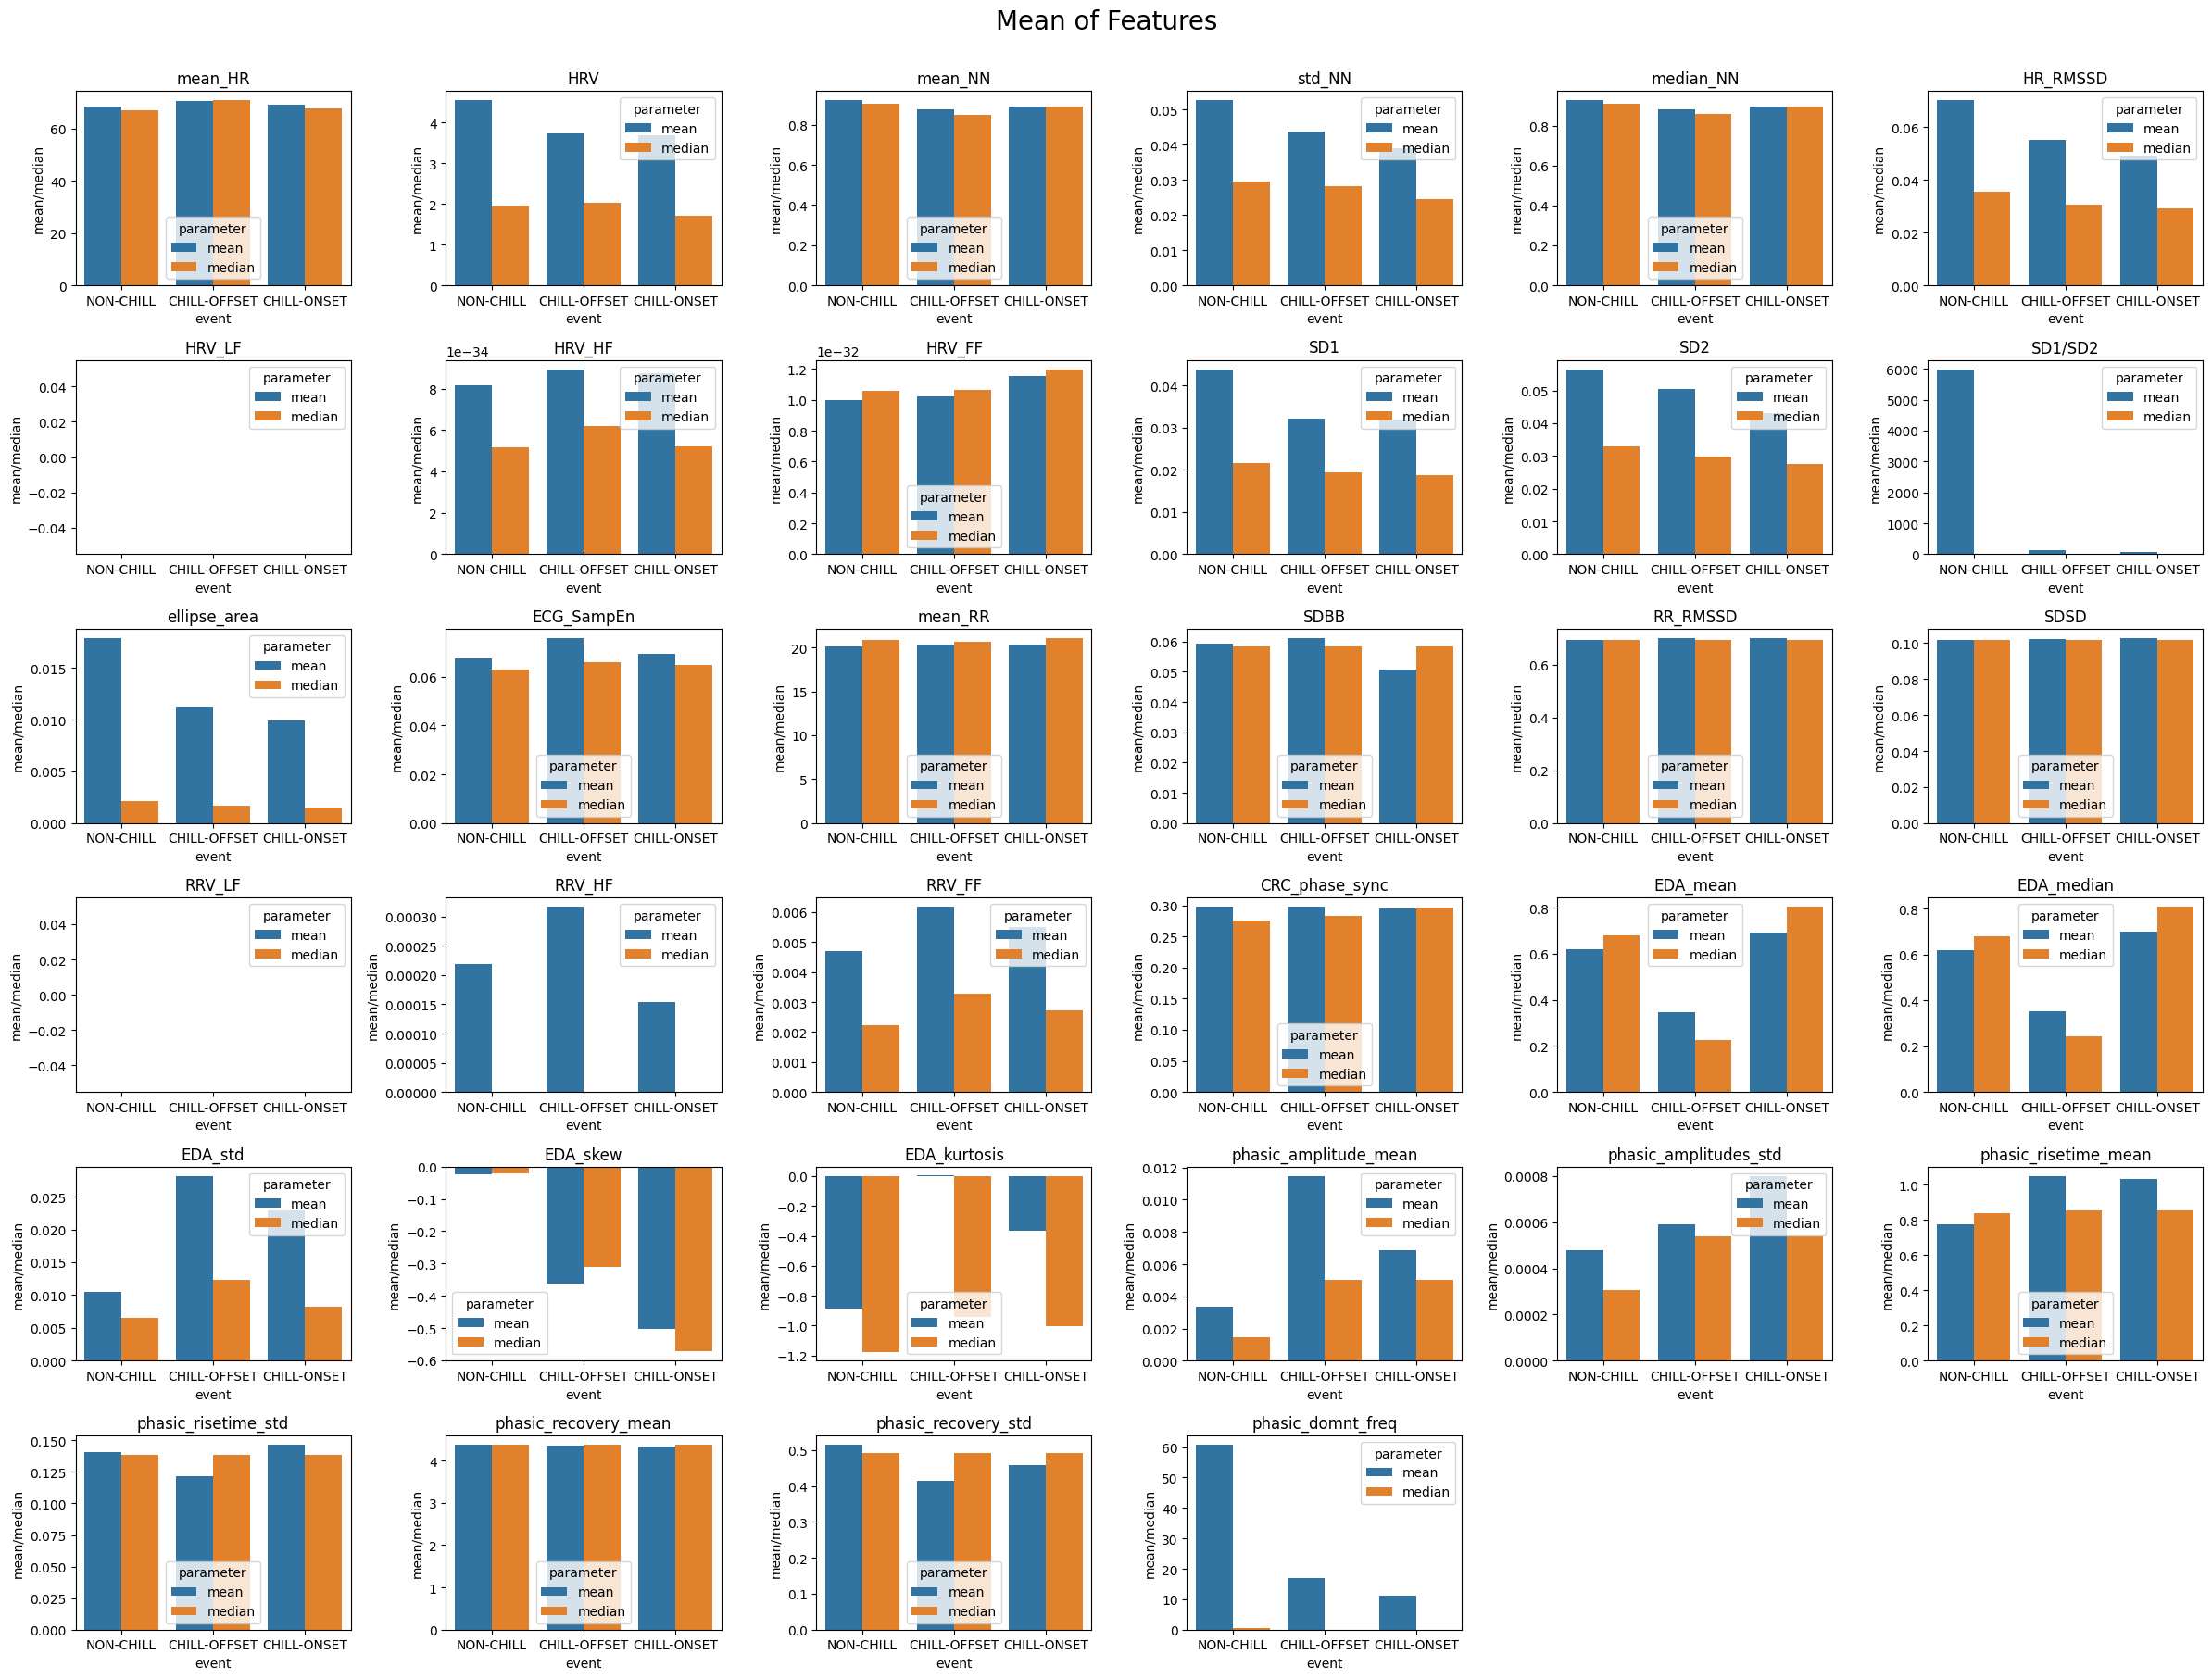

In [ ]:
nrows = ncols = math.ceil(math.sqrt(non_chills_stats.shape[1]))
fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = non_chills_stats.columns
for x_idx, x in enumerate(xs):

  # y_ = [stats.loc["mean"][x] for stats in [non_chills_stats, pre_chills_stats, post_chills_stats, chills_stats]]
  # y_ += [stats.loc["50%"][x] for stats in [non_chills_stats, pre_chills_stats, post_chills_stats, chills_stats]]
  # label = ["NON-CHILL", "PRE-CHILL", "POST-CHILL", "CHILL"]*2
  # stat = ["mean"]*4 + ["median"]*4

  y_ = [stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]
  y_ += [stats.loc["50%"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]
  label = ["NON-CHILL", "CHILL-OFFSET", "CHILL-ONSET"]*3
  stat = ["mean"]*3 + ["median"]*3

  df = pd.DataFrame([y_, label, stat], ["mean/median", "event", "parameter"]).T
  sns.barplot(df, y="mean/median", x="event", hue="parameter", ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Mean of Features", y=1.005, fontsize=20)
fig.tight_layout()

fig.savefig("plots/features_mean_median.png")

<ipython-input-99-b692402ffbb8>:10: RuntimeWarning: invalid value encountered in scalar divide
  y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]


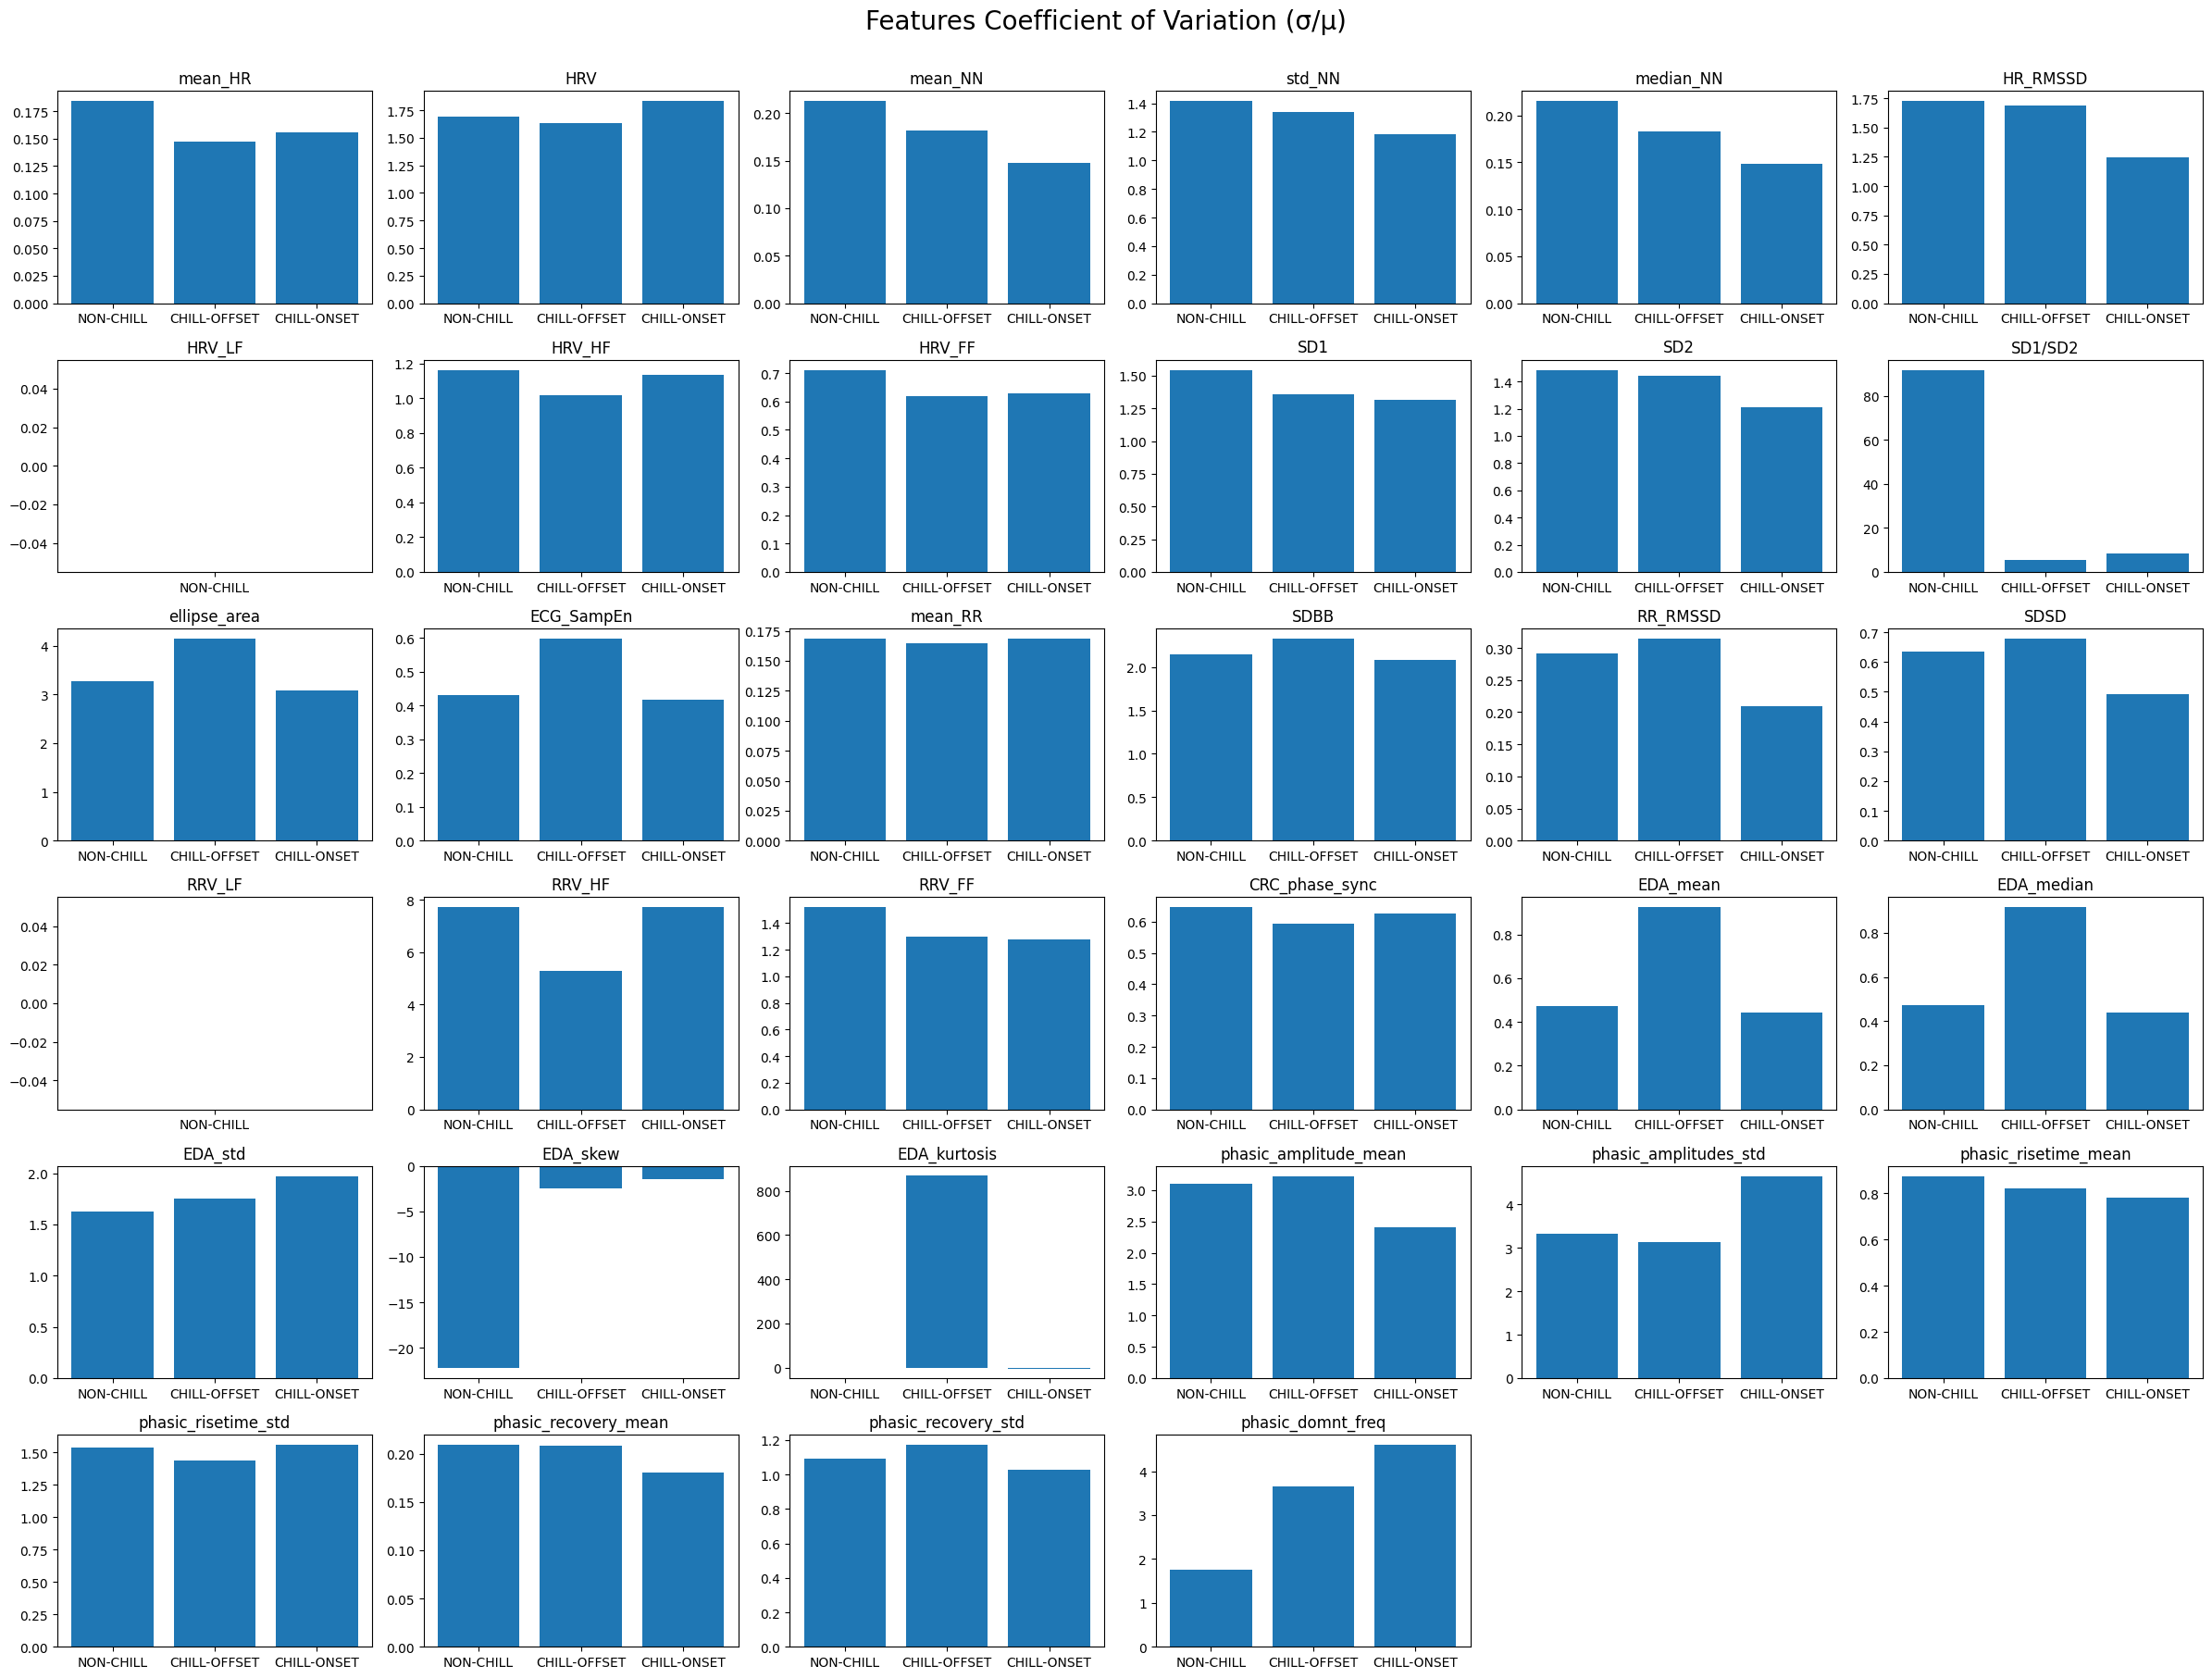

In [ ]:
nrows = ncols = math.ceil(math.sqrt(non_chills_stats.shape[1]))
fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = non_chills_stats.columns
for x_idx, x in enumerate(xs):
  # x_ = ["NON-CHILL", "PRE-CHILL", "POST-CHILL", "CHILL"]
  # y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, pre_chills_stats,  post_chills_stats, chills_stats]]

  x_ = ["NON-CHILL", "CHILL-OFFSET", "CHILL-ONSET"]
  y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]

  ax_.flatten()[x_idx].bar(x_, y_)
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Coefficient of Variation (σ/μ)", y=1.005, fontsize=20)
fig.tight_layout()

fig.savefig("plots/coefficient_of_variation.png")

#### View Distributions

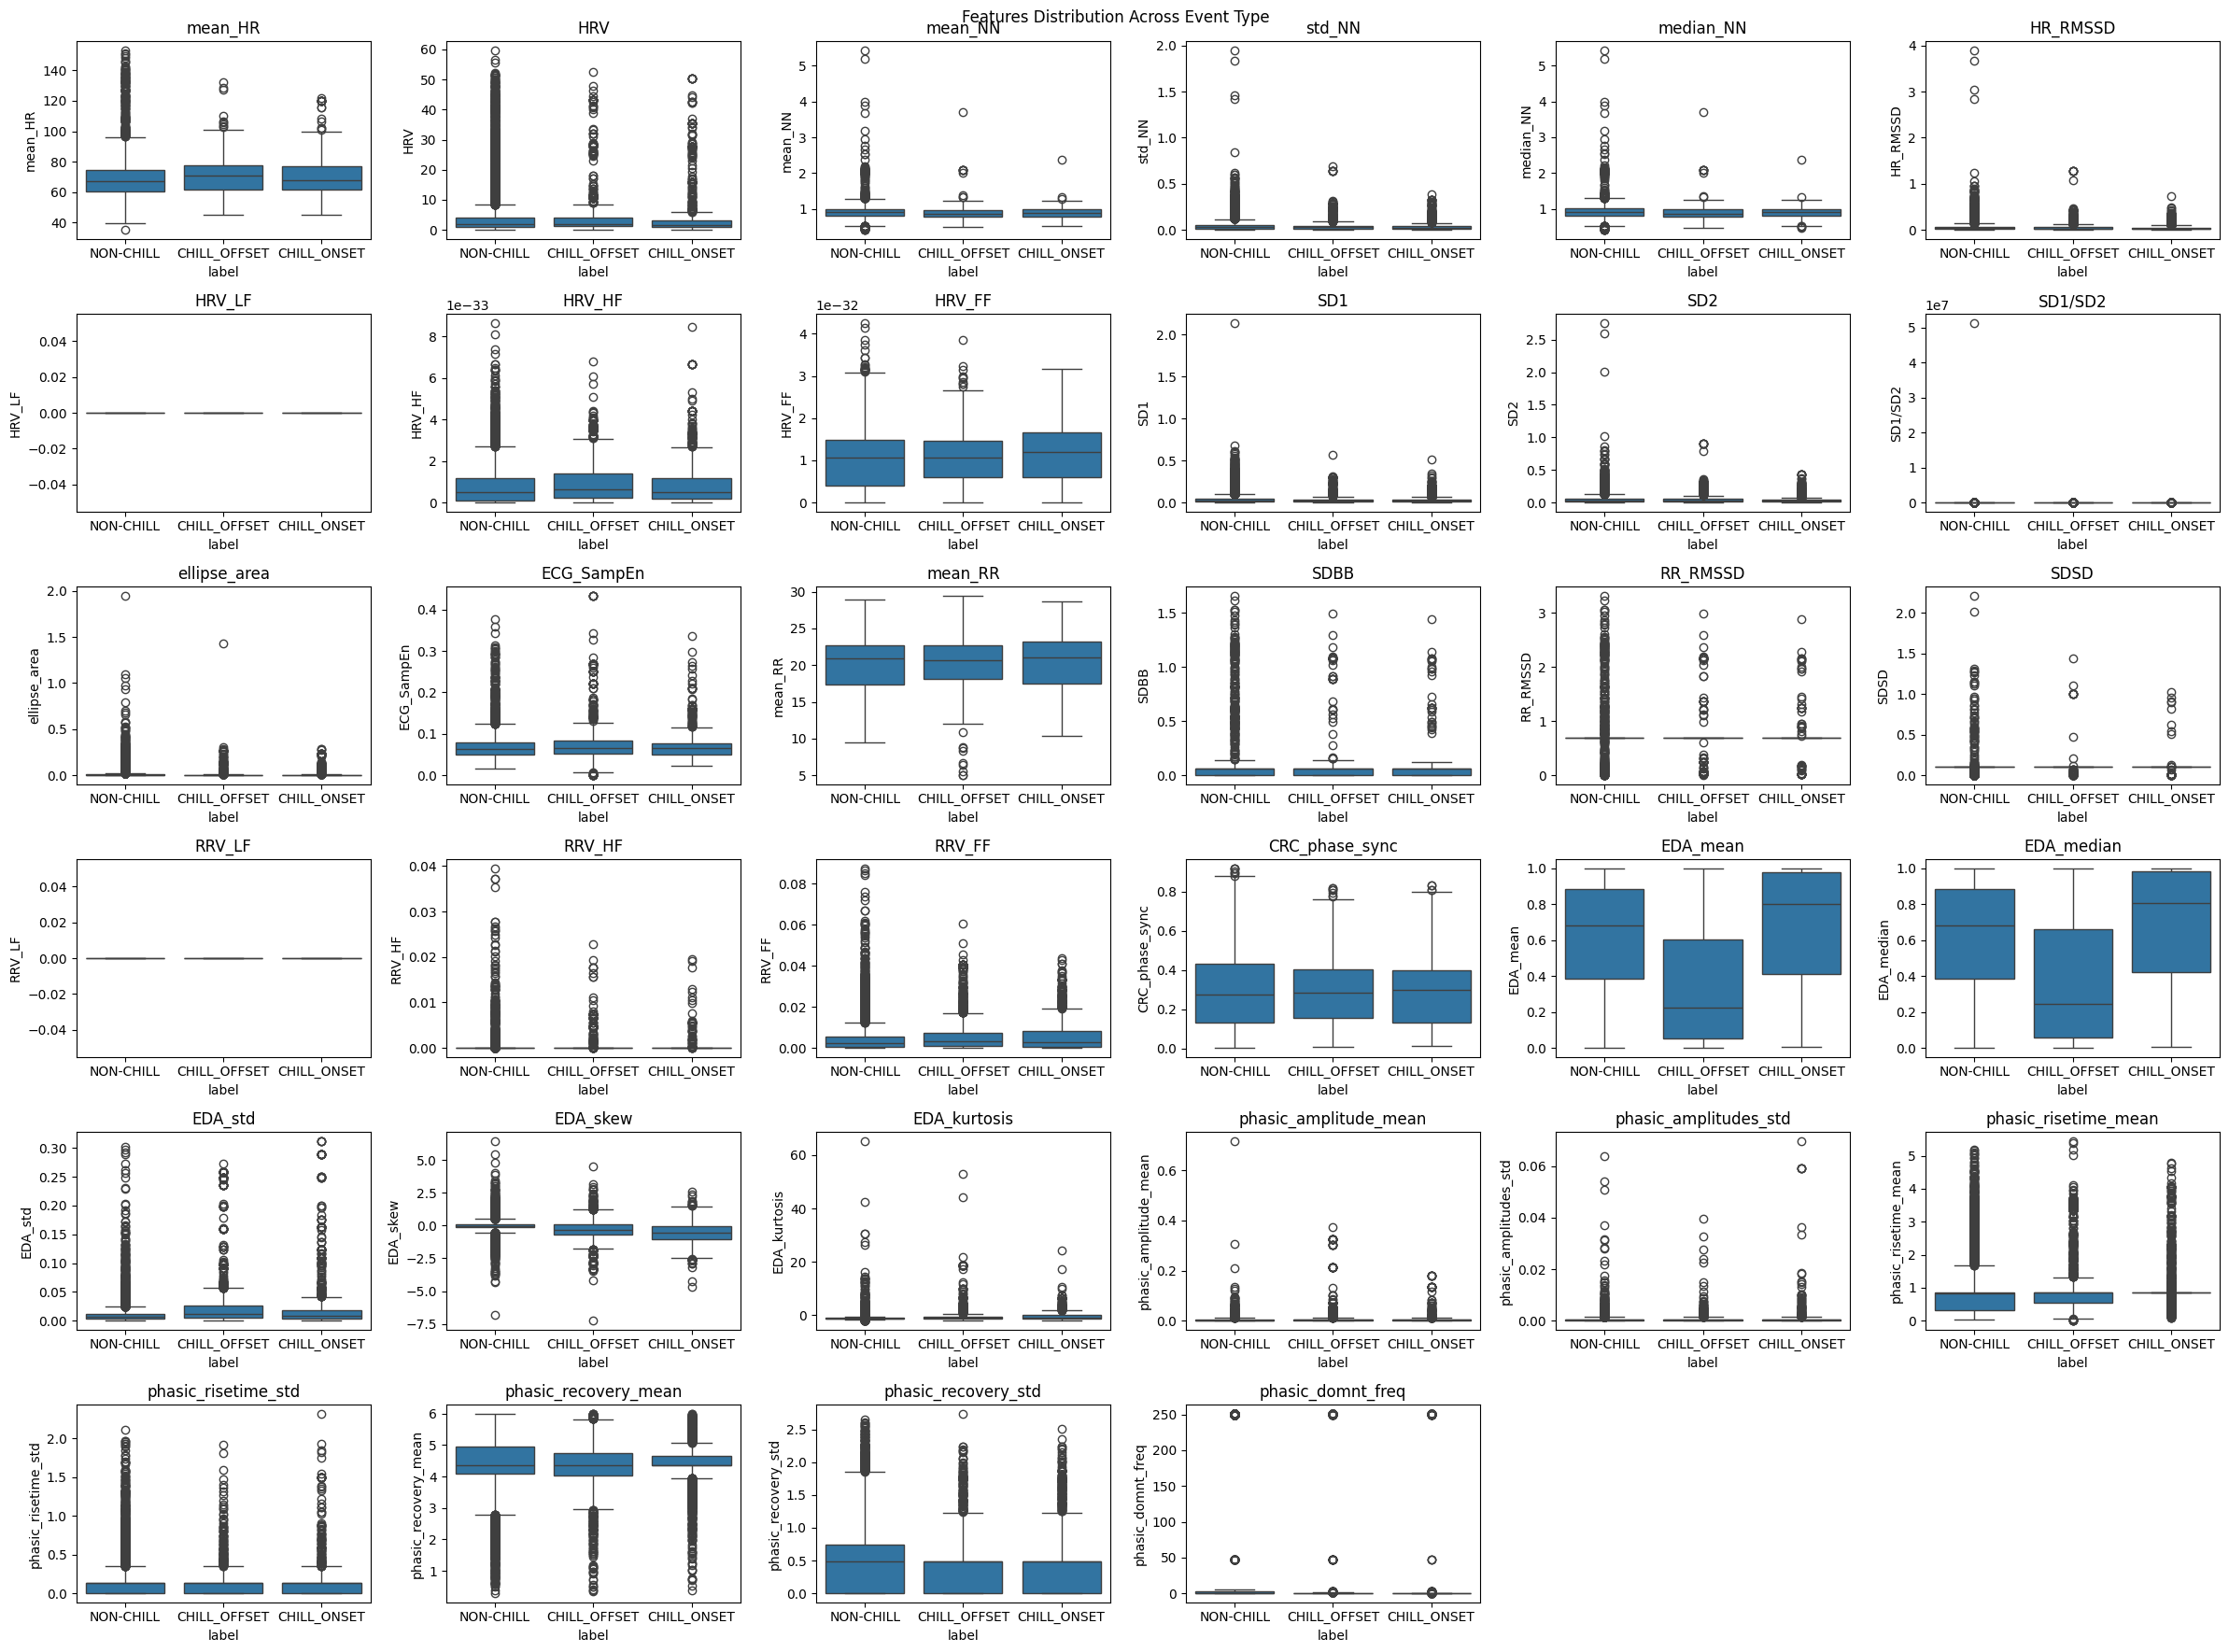

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  sns.boxplot(features, x="label", y=x, ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_dist_box.png")

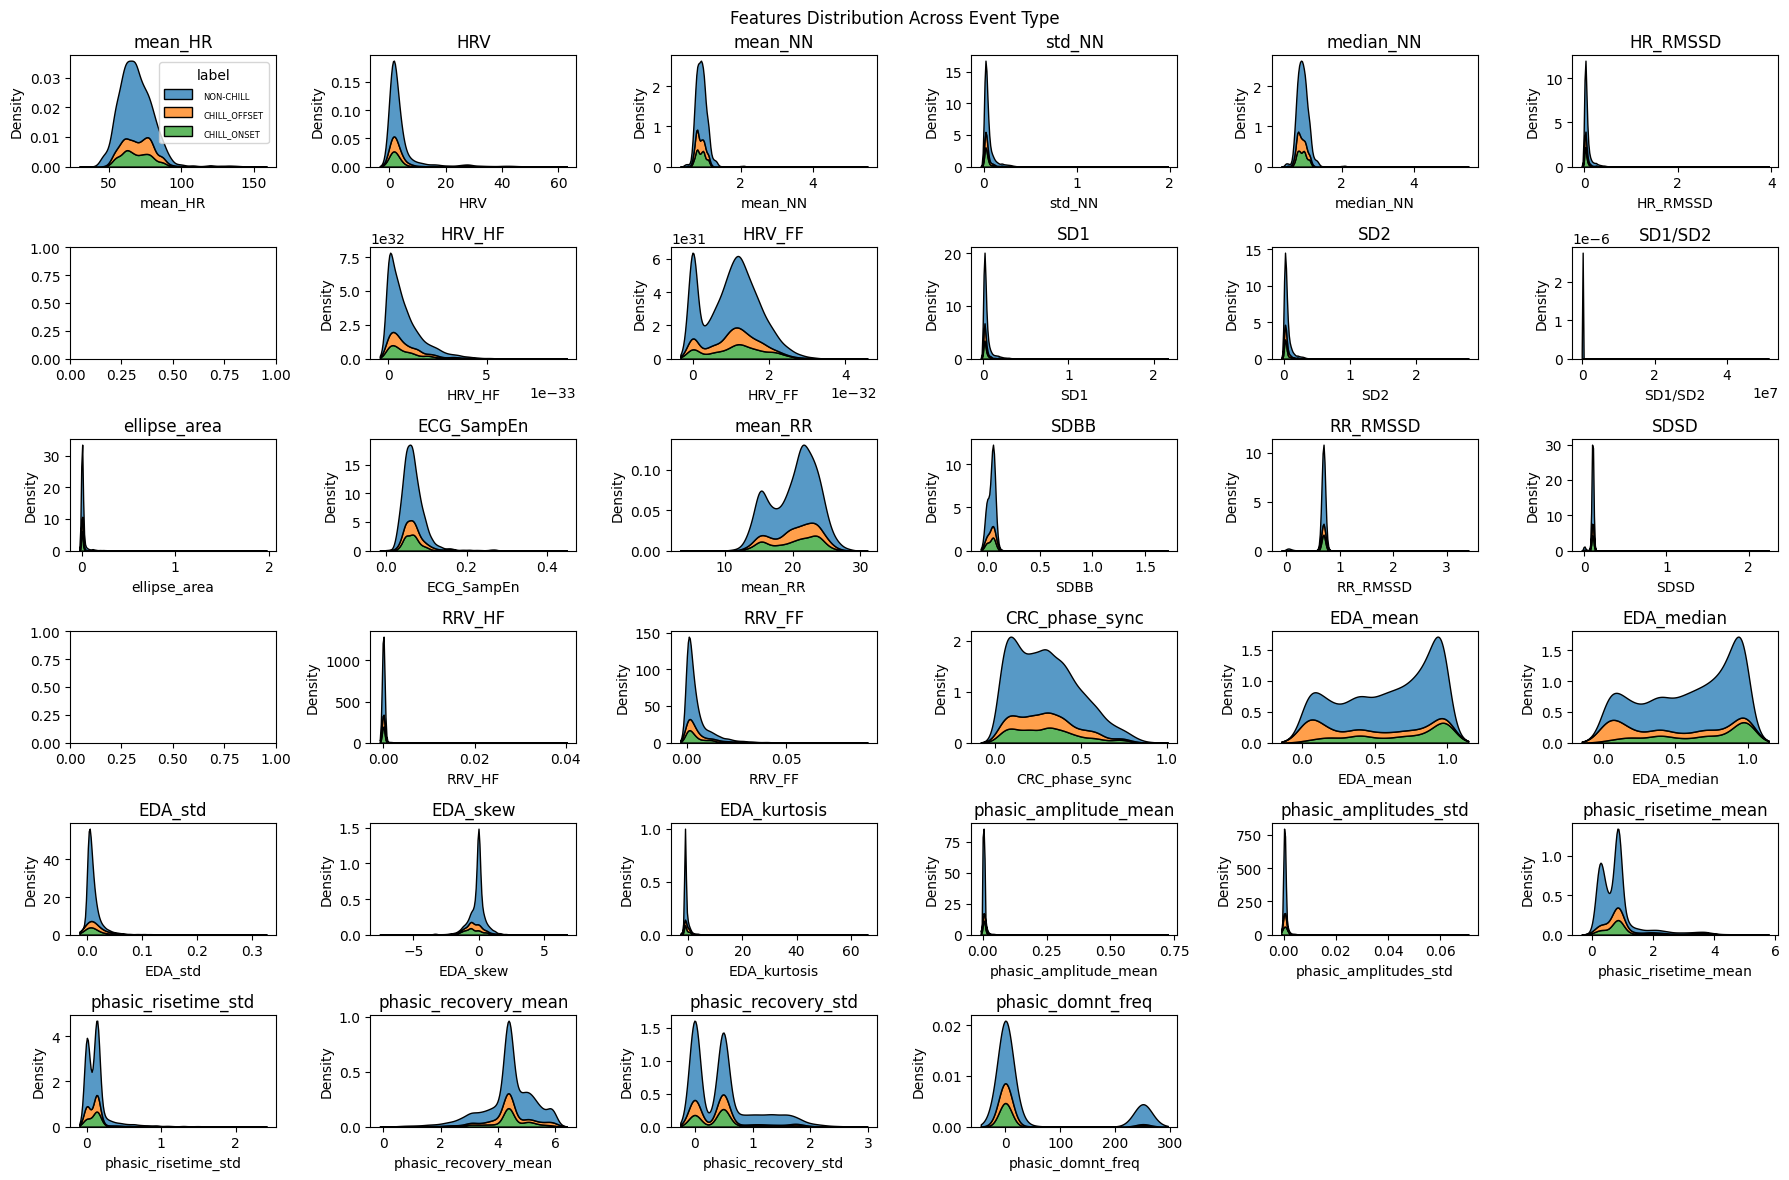

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  try:
    sns.kdeplot(features, x=x, hue="label", ax=ax_.flatten()[x_idx], multiple="stack")
    ax_.flatten()[x_idx].set_title(x)

    # Set legend size
    if x_idx != 0:
      ax_.flatten()[x_idx].legend_.remove()
    else:
      legend = ax_.flatten()[x_idx].legend_
      if legend:
          for text in legend.get_texts():
              text.set_fontsize(6)  # Adjust font size
  except:
    pass

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_dist_kde.png")

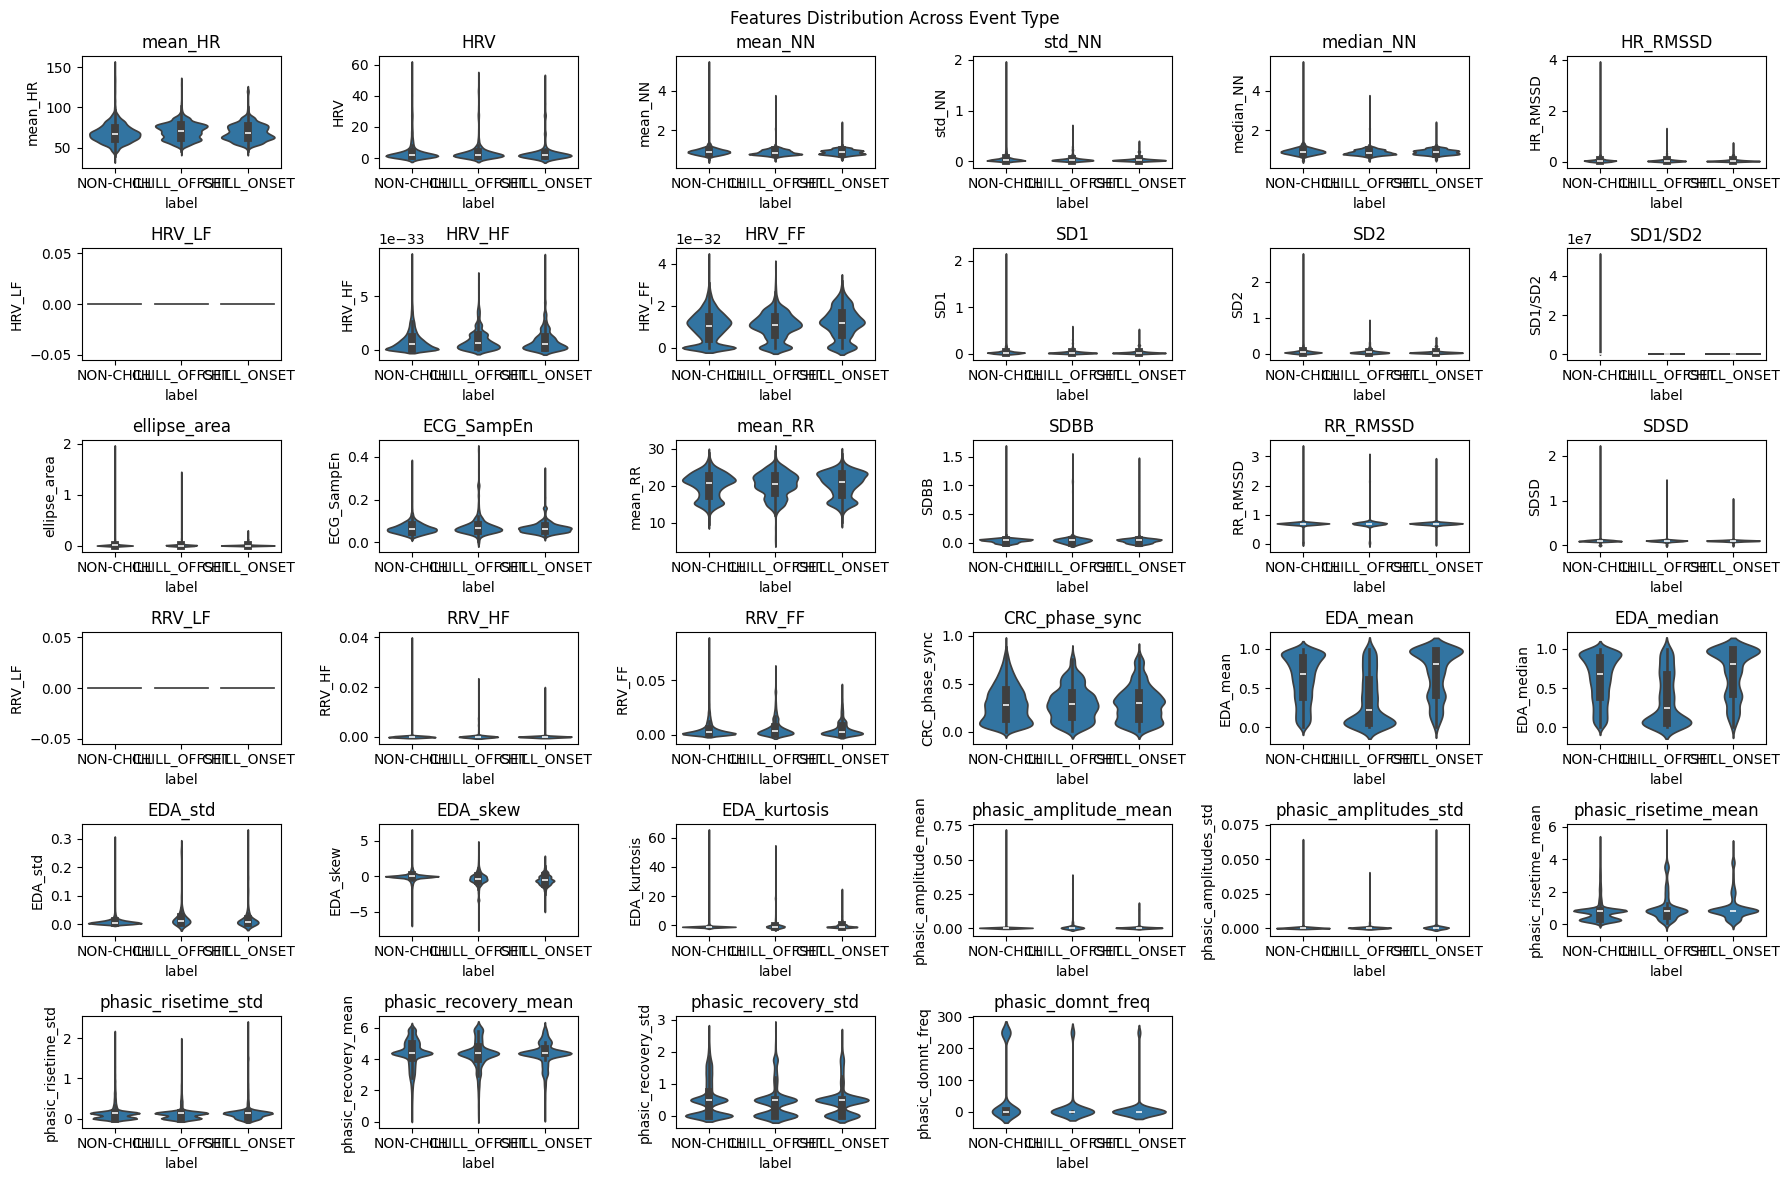

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  sns.violinplot(features, x="label", y=x, ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_violin_box.png")

#### Selecting Relevant Features - F test

In [ ]:
# @title F-Test & Mutual Information

# X = features.drop("label", axis=1)
X = features
y = all_df["label"]

f_scores, p_values = f_classif(X, y)
mi_scores = mutual_info_classif(X,y)
rejected, corrected_pvals = multipletests(p_values, alpha=0.01, method='fdr_bh')[:-2]

importance_df = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores,
    "p_value": p_values,
    "mi_score": mi_scores,
    "FDR_rejected": rejected,
    "FDR_corrected_pval": corrected_pvals
})

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 6 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


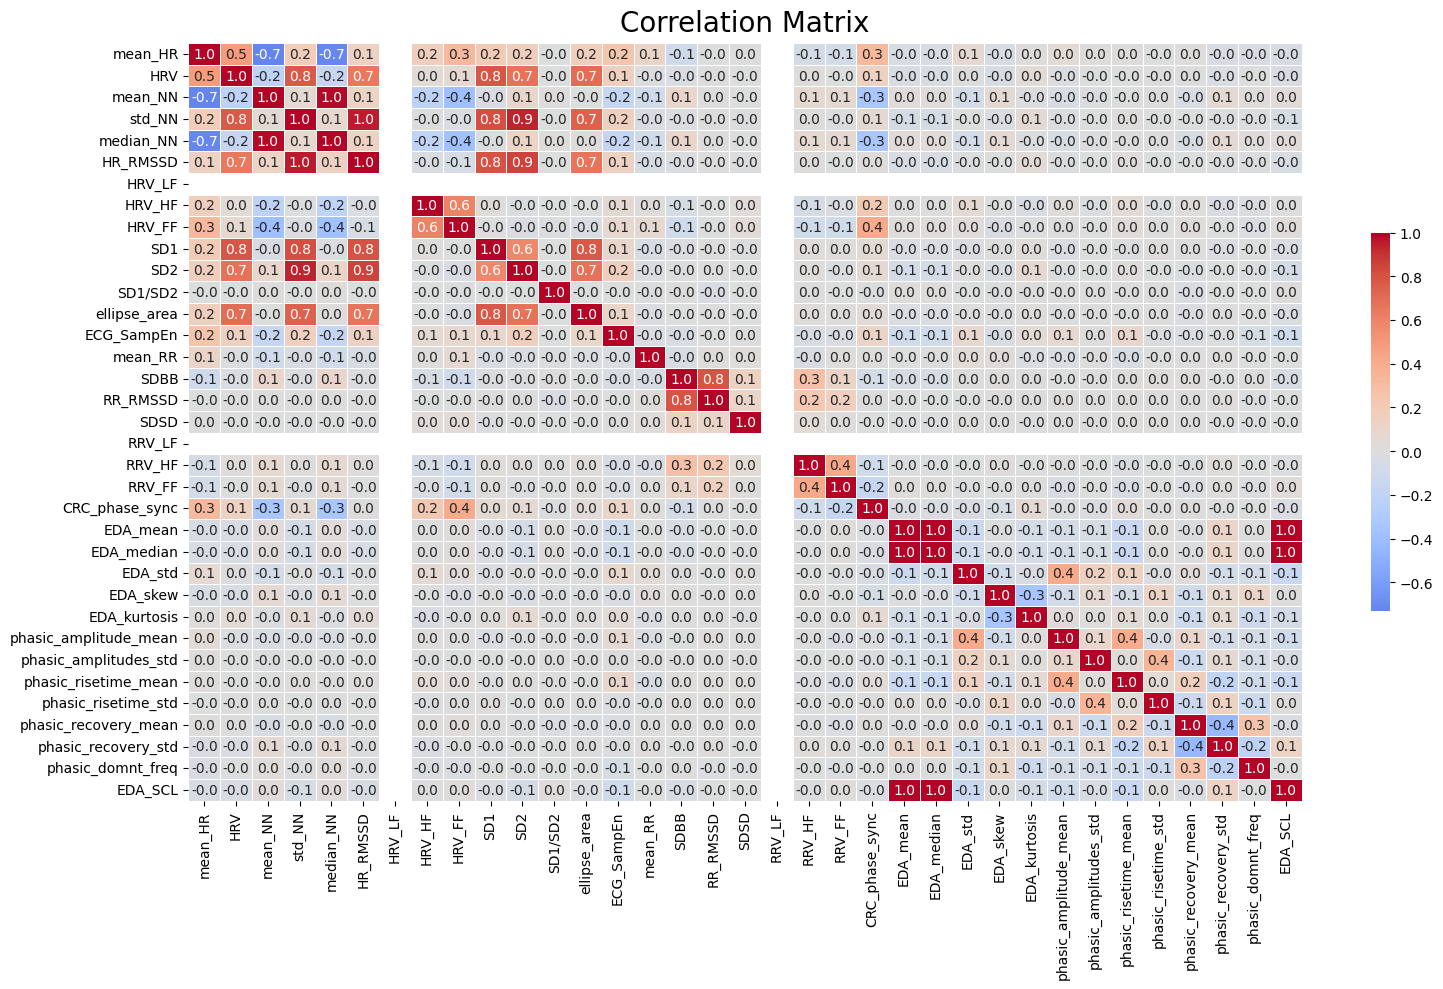

In [ ]:
# @title Correlation Matrix

# corr_matx = features.drop(["label"], axis=1, inplace=False).corr()
corr_matx = features.corr()

plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matx, dtype=bool))
# sns.heatmap(corr_matx, mask=mask, annot=True, cmap="coolwarm", center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
sns.heatmap(corr_matx, annot=True, cmap="coolwarm", center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Correlation Matrix", y=1.005, fontsize=20)
plt.tight_layout()
plt.savefig("plots/relevant_features_corr.png")


Highly correlated features (|r| >= 0.35):
mean_HR -- HRV: 0.489
mean_HR -- mean_NN: -0.733
mean_HR -- median_NN: -0.721
HRV -- mean_HR: 0.489
HRV -- std_NN: 0.763
HRV -- HR_RMSSD: 0.651
HRV -- SD1: 0.783
HRV -- SD2: 0.674
HRV -- ellipse_area: 0.699
mean_NN -- mean_HR: -0.733
mean_NN -- median_NN: 0.985
mean_NN -- HRV_FF: -0.388
std_NN -- HRV: 0.763
std_NN -- HR_RMSSD: 0.958
std_NN -- SD1: 0.813
std_NN -- SD2: 0.935
std_NN -- ellipse_area: 0.746
median_NN -- mean_HR: -0.721
median_NN -- mean_NN: 0.985
median_NN -- HRV_FF: -0.378
HR_RMSSD -- HRV: 0.651
HR_RMSSD -- std_NN: 0.958
HR_RMSSD -- SD1: 0.803
HR_RMSSD -- SD2: 0.853
HR_RMSSD -- ellipse_area: 0.663
HRV_HF -- HRV_FF: 0.603
HRV_FF -- mean_NN: -0.388
HRV_FF -- median_NN: -0.378
HRV_FF -- HRV_HF: 0.603
HRV_FF -- CRC_phase_sync: 0.409
SD1 -- HRV: 0.783
SD1 -- std_NN: 0.813
SD1 -- HR_RMSSD: 0.803
SD1 -- SD2: 0.581
SD1 -- ellipse_area: 0.773
SD2 -- HRV: 0.674
SD2 -- std_NN: 0.935
SD2 -- HR_RMSSD: 0.853
SD2 -- SD1: 0.581
SD2 -- ellipse_ar

<ipython-input-17-a70a2f549f65>:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


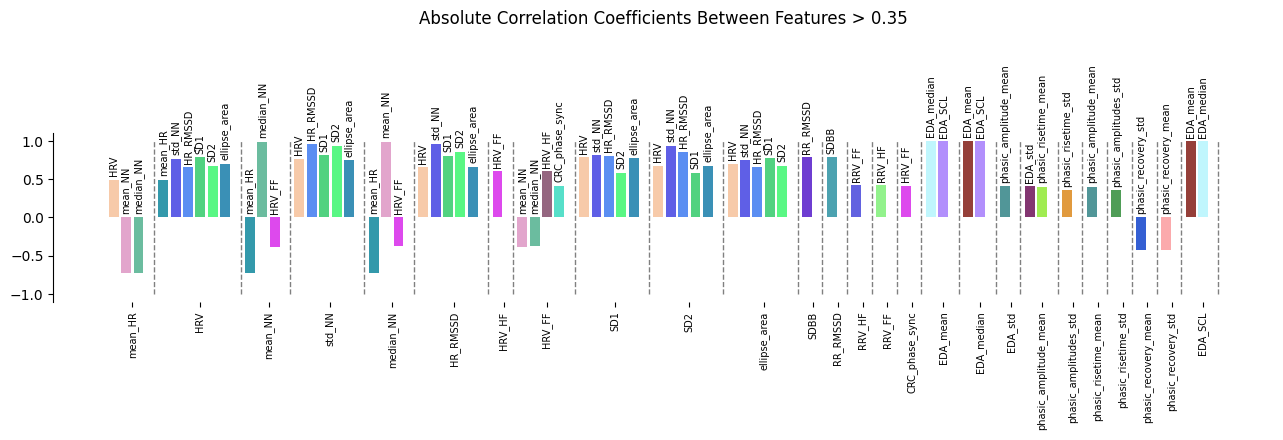

In [ ]:
# @title Best Correlations

threshold = 0.35
correlated_variables = []
high_corr = np.where(np.abs(corr_matx) >= threshold)
high_corr = [[x, y]
              for x, y in zip(*high_corr) if x != y]
if high_corr:
    print(f"\nHighly correlated features (|r| >= {threshold}):")
    for x, y in high_corr:
        print(f"{corr_matx.index[x]} -- {corr_matx.columns[y]}: {corr_matx.iloc[x, y]:.3f}")
        correlated_variables.append(corr_matx.index[x])
        correlated_variables.append(corr_matx.index[y])

correlated_variables = list(set(correlated_variables))


num_columns = len(corr_matx.columns)
# cmap = get_cmap('tab20b', num_columns)  # Use a colormap with enough distinct colors
# color_map = {col: cmap(i) for i, col in enumerate(corr_matx.columns)}
color_map = {col: (random.random(), random.random(), random.random(), 0.8) for i, col in enumerate(corr_matx.columns)}

high_corr = np.array(high_corr)

xs, ys = high_corr[:,0], high_corr[:,1]
figure = plt.figure(figsize=(threshold*45, threshold*25/4))
xticks, xlabels = [], []
legend_handles = []

x_pos = 0
for x_idx, x in enumerate(np.unique(xs)):

  y_idx = np.where(xs==x)[0]
  corrs = np.array(corr_matx.iloc[x, ys[y_idx]])

  # legend_handles += [plt.Line2D([0], [0], color=color_map[corr_matx.columns[y_]],
  #                               lw=4, label=corr_matx.columns[y_]) for y_ in ys[y_idx]]

  plt.bar([x_pos + i for i in range(len(corrs))], corrs, color=[color_map[corr_matx.columns[y_]] for y_ in ys[y_idx]])

  for x_, y_, y_id in zip([x_pos + i for i in range(len(corrs))], corrs, ys[y_idx]):
    y_  = (y_ + 0.05) if y_ > 0 else (0 + 0.05)
    plt.text(x_, y_, corr_matx.columns[y_id], rotation=90, ha='center', va='bottom', fontsize=7)

  plt.vlines(x_pos + len(corrs) + 0.25, -1, 1, "gray", linestyle='--', linewidth=1)
  xticks.append((x_pos + (x_pos + len(corrs))) / 2)
  xlabels.append(corr_matx.columns[x])
  x_pos += len(corrs) + 1

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(xticks, xlabels, fontsize=7, rotation=90)
# plt.ylim(-1.05, 1.05)
plt.title(f"Absolute Correlation Coefficients Between Features > {threshold}", y=1.6)
plt.tight_layout()
plt.savefig("plots/highest_correlations", bbox_inches="tight")

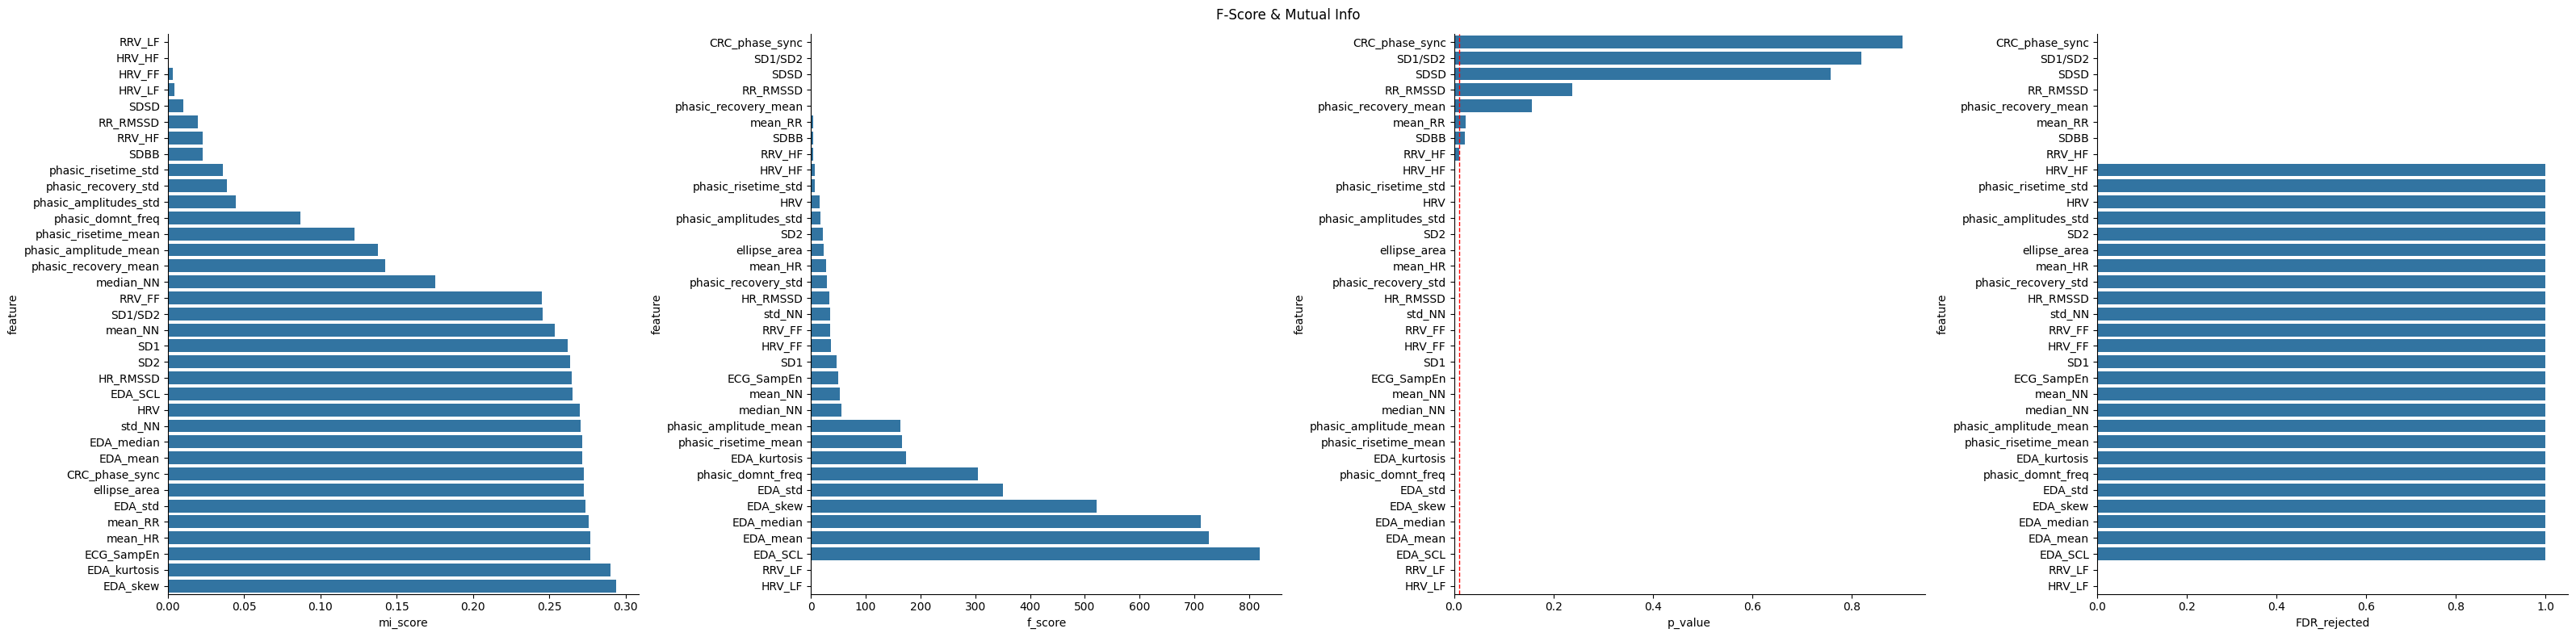

In [ ]:
# @title F-Test & Mutual Information Plot

fig, ax_ = plt.subplots(1, 4, figsize=(32, 8))

importance_df = importance_df.sort_values(by="mi_score", ascending=True)
sns.barplot(data=importance_df, x="mi_score", y="feature", ax=ax_[0])

importance_df = importance_df.sort_values(by="p_value", ascending=False)
# importance_df = importance_df.sort_values(by="f_score", ascending=False)
sns.barplot(data=importance_df, x="f_score", y="feature", ax=ax_[1])
# importance_df = importance_df.sort_values(by="p_value", ascending=False)
sns.barplot(data=importance_df, x="p_value", y="feature", ax=ax_[2])
sns.barplot(data=importance_df, x="FDR_rejected", y="feature", ax=ax_[3])

ax_[2].axvline(x=0.01, color='red', linestyle='--', linewidth=1)

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("F-Score & Mutual Info")
plt.tight_layout()

fig.savefig("plots/feature_importance.png")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


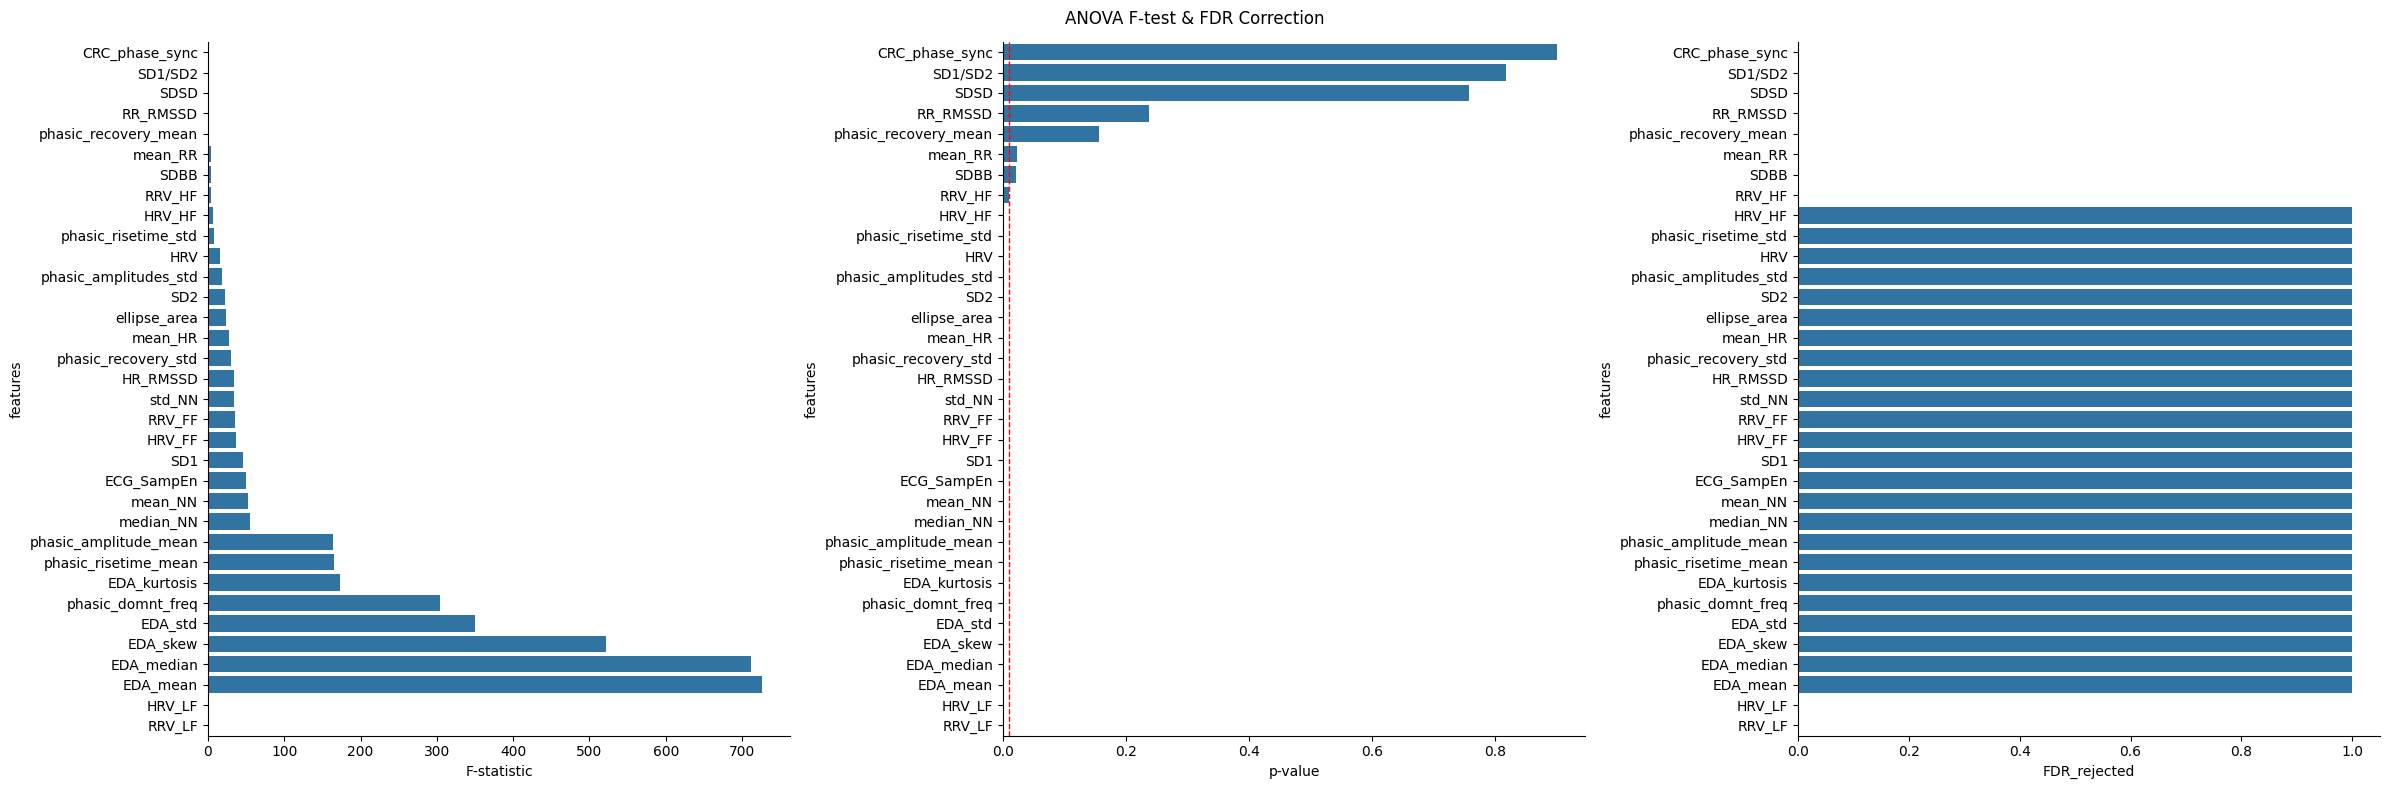

In [ ]:
# ## # @title ANOVA

from scipy.stats import f_oneway

anova_result = {}

for feature in all_df.columns[3:-1]:
    groups = [all_df[all_df['label']==cls][feature] for cls in all_df['label'].unique()]
    f_value, p_value = f_oneway(*groups)
    anova_result[feature] = {'F-statistic': f_value, 'p-value': p_value}

anova_result = pd.DataFrame(anova_result).T
rejected, corrected_pvals = multipletests(anova_result['p-value'], alpha=0.01, method='fdr_bh')[:-2]
anova_result['FDR_rejected'] = rejected
anova_result['FDR_corrected_pval'] = corrected_pvals
p_val_sorted_anova = anova_result.sort_values(by='p-value', ascending=False)
p_val_sorted_anova["features"] = p_val_sorted_anova.index

fig, ax_ = plt.subplots(1, 3, figsize=(24,8))

sns.barplot(data=p_val_sorted_anova, x='F-statistic', y='features', ax=ax_[0])
sns.barplot(data=p_val_sorted_anova, x='p-value', y='features', ax=ax_[1])
sns.barplot(data=p_val_sorted_anova, x='FDR_rejected', y='features', ax=ax_[2])

ax_[1].axvline(x=0.01, color='red', linestyle='--', linewidth=1)

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("ANOVA F-test & FDR Correction")
fig.tight_layout()

fig.savefig("plots/feature_importance_anova.png")

#### Dimesionality Reduction On Most Correlatied & Statistically Significant Features

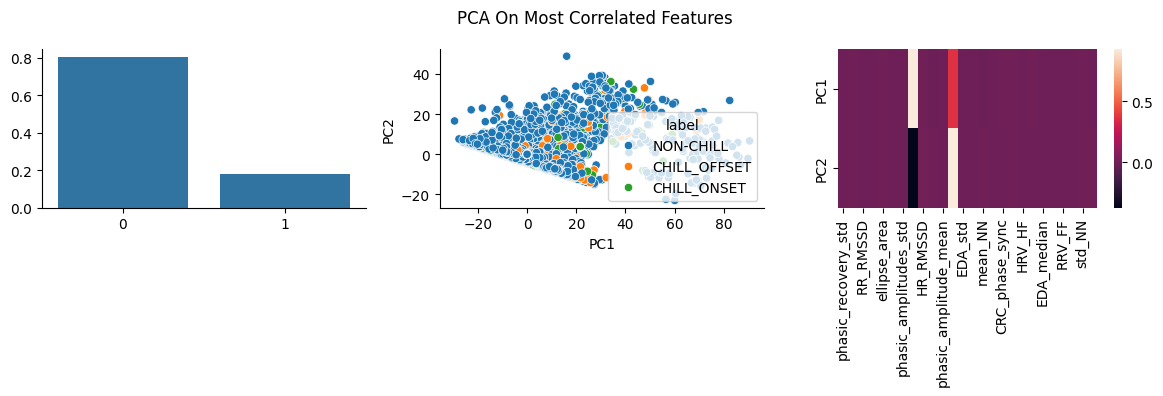

In [ ]:
# @title Most Correlated Features

len(correlated_variables), len(all_df.columns)-2

features = all_df[correlated_variables+["label"]]

from sklearn.decomposition import PCA
pca_ = PCA(2)

latent_space = pca_.fit_transform(features[features.columns[:-1]])
latent_space = pd.DataFrame(latent_space, columns=[f"PC{i+1}" for i in range(latent_space.shape[1])])
latent_space["label"] = features["label"]

fig, ax_ = plt.subplots(1, 3, figsize=(12,4))

sns.barplot(pca_.explained_variance_ratio_, ax=ax_[0])
sns.scatterplot(data=latent_space, x="PC1", y="PC2", hue="label", ax=ax_[1])
vars_ = pd.DataFrame(pca_.components_, columns=features.columns[:-1], index=[f"PC{i+1}" for i in range(latent_space.shape[1]-1)])
sns.heatmap(vars_, ax=ax_[2])

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("PCA On Most Correlated Features")
fig.tight_layout()

fig.savefig("plots/PCA_best_correlated_features.png", bbox_inches="tight")

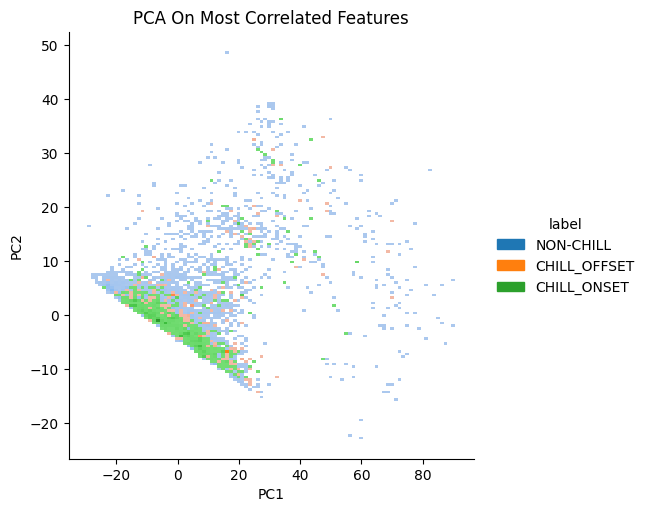

In [ ]:
sns.displot(latent_space, x="PC1", y="PC2", hue="label")
plt.title("PCA On Most Correlated Features")
plt.savefig("plots/PCA_MCF_dist.png", bbox_inches="tight")

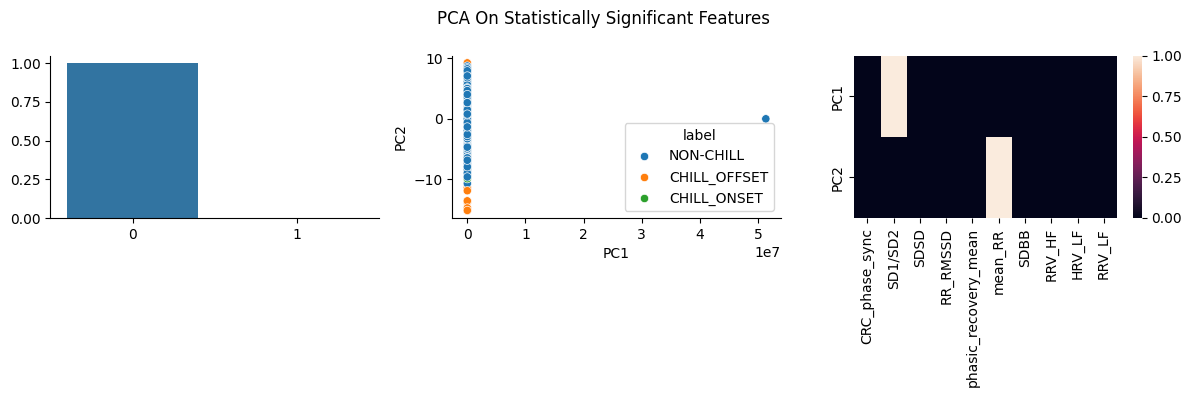

In [ ]:
# @title Statistically Significant Features

SSFs = ["CRC_phase_sync", "SD1/SD2", "SDSD", "RR_RMSSD", "phasic_recovery_mean", "mean_RR", "SDBB", "RRV_HF", "HRV_LF", "RRV_LF"]

features = all_df[SSFs+["label"]]

from sklearn.decomposition import PCA
pca_ = PCA(2)

latent_space = pca_.fit_transform(features[features.columns[:-1]])
latent_space = pd.DataFrame(latent_space, columns=[f"PC{i+1}" for i in range(latent_space.shape[1])])
latent_space["label"] = features["label"]

fig, ax_ = plt.subplots(1, 3, figsize=(12,4))

sns.barplot(pca_.explained_variance_ratio_, ax=ax_[0])
sns.scatterplot(data=latent_space, x="PC1", y="PC2", hue="label", ax=ax_[1])
vars_ = pd.DataFrame(pca_.components_, columns=features.columns[:-1], index=[f"PC{i+1}" for i in range(latent_space.shape[1]-1)])
sns.heatmap(vars_, ax=ax_[2])

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("PCA On Statistically Significant Features")
fig.tight_layout()

fig.savefig("plots/PCA_SSF_features.png", bbox_inches="tight")

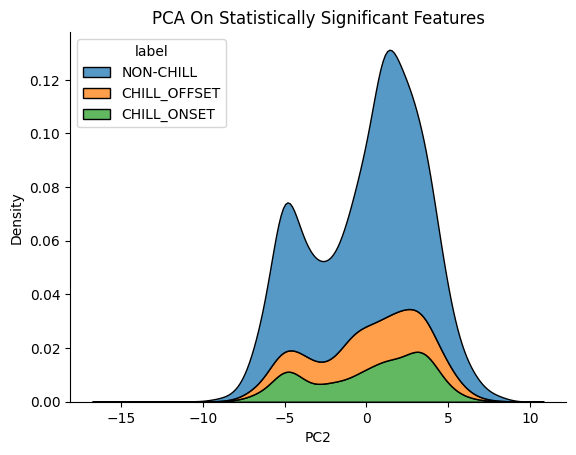

In [ ]:
# latent_space

sns.kdeplot(latent_space, x="PC2", hue="label", multiple="stack")
plt.title("PCA On Statistically Significant Features")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig("plots/PCA_SSF_dist.png", bbox_inches="tight")

# Download Artifacts

In [ ]:
# @title Download Plots

import shutil
from google.colab import files

plots = shutil.make_archive("plots", "zip", "plots")

files.download("plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# Run Scripts

In [ ]:
! python feature_extraction.py
# clear_output(wait=True)
# time.sleep(0.5)
print("Features Extraction Script Run Complete")

Extracting Features:  81% 93/115 [2:52:36<45:34, 124.30s/it]^C
Features Extraction Script Run Complete


In [ ]:
extracted_data = {
    "ORGANIC": joblib.load("drive/MyDrive/chills_dataset/processed/organic_chills_signal.sav"),
    "AUGMENTED": joblib.load("drive/MyDrive/chills_dataset/processed/augmented_chills_signal.sav"),
    "SIMULATED": joblib.load("drive/MyDrive/chills_dataset/processed/simulated_chills_signal.sav"),
    "NON": joblib.load("drive/MyDrive/chills_dataset/processed/non_chills_signal.sav"),
}